# Plot BesNet Loss

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
from datetime import datetime
import sys
import gc
sys.path.append('../../')

from sklearn.model_selection import KFold
from tqdm import tqdm

from dependencies import *
from settings import *
from reproducibility import *
from models.TGS_salt.BesNet import BesNet as Net

Using paths on kail-main

Importing numerical libraries...
Importing standard libraries...
Importing miscellaneous functions...
Importing constants...
Importing Neural Network dependencies...
	PyTorch
	Keras
	TensorFlow
	Metrics, Losses and LR Schedulers
	Kaggle Metrics
	Image augmentations
	Datasets
Importing external libraries...
	Lovasz Losses (elu+1)

Fixing random seed for reproducibility...
	Setting random seed to 35202.

Setting CUDA environment...
	torch.__version__              = 1.1.0
	torch.version.cuda             = 9.0.176
	torch.backends.cudnn.version() = 7501
	os['CUDA_VISIBLE_DEVICES']     = 0,1
	torch.cuda.device_count()      = 2



In [2]:
SIZE = 256
FACTOR = SIZE
ne = "ne"
initial_checkpoint = None
MODEL = "ResNet34"

batch_size = 8
n_acc = 256 / batch_size
nfolds = 4

noise_th = 75.0*(SIZE/128.0)**2 #threshold for the number of predicted pixels
best_thr0 = 0.2 #preliminary value of the threshold for metric calculation

data_root = '../../data/siim-pneumothorax'
torch.cuda.set_device('cuda:1')

In [3]:
def valid_augment(image,mask,index):
    cache = Struct(image = image.copy(), mask = mask.copy())
    # image, mask = do_resize2(image, mask, SIZE, SIZE)
    # image, mask = do_center_pad_to_factor2(image, mask, factor = FACTOR)
    return image,mask,index,cache

def train_augment(image,mask,index):
    cache = Struct(image = image.copy(), mask = mask.copy())

    if np.random.rand() < 0.5:
         image, mask = do_horizontal_flip2(image, mask)
         pass

    if np.random.rand() < 0.2:
        c = np.random.choice(4)
        if c==0:
            image, mask = do_random_shift_scale_crop_pad2(image, mask, 0.1) #0.125

        if c==1:
            image, mask = do_horizontal_shear2( image, mask, dx=np.random.uniform(-0.02,0.02) )
            pass

        if c==2:
            image, mask = do_shift_scale_rotate2( image, mask, dx=0, dy=0, scale=1, angle=np.random.uniform(0,15))  #10

        if c==3:
            image, mask = do_elastic_transform2(image, mask, grid=10, distort=np.random.uniform(0,0.05))#0.10
            pass
    if np.random.rand() < 0.1:
        c = np.random.choice(3)
        if c==0:
            image = do_brightness_shift(image,np.random.uniform(-0.1,+0.1))
        if c==1:
            image = do_brightness_multiply(image,np.random.uniform(1-0.08,1+0.08))
        if c==2:
            image = do_gamma(image,np.random.uniform(1-0.08,1+0.08))
        # if c==1:
        #     image = do_invert_intensity(image)

    # image, mask = do_resize2(image, mask, SIZE, SIZE)
    # image, mask = do_center_pad_to_factor2(image, mask, factor = FACTOR)
    return image,mask,index,cache

In [4]:
def null_augment(image, mask, index):
    cache = Struct(image = image.copy(), mask = mask.copy())
    return image, mask, index, cache

def null_collate(batch):

    batch_size = len(batch)
    cache = []
    input = []
    truth = []
    index = []
    for b in range(batch_size):
        input.append(batch[b][0])
        truth.append(batch[b][1])
        index.append(batch[b][2])
        cache.append(batch[b][3])
    input = torch.from_numpy(np.array(input)).float().unsqueeze(1)

    if truth[0]!=[]:
        truth = torch.from_numpy(np.array(truth)).float().unsqueeze(1)

    return input, truth, index, cache

def get_weights_for_balanced_classes(cls_list, num_classes):
    # get count per class
    count = [0] * num_classes
    
    for cls in cls_list:
        count[cls] += 1

    # get weight per class
    weight_per_class = [0.] * num_classes
    N = float(len(cls_list))
    
    for i in range(num_classes):
        weight_per_class[i] = N / float(count[i])
        
    #　get weight per sample
    weights = [0] * len(cls_list)
    
    for i, cls in enumerate(cls_list):
        weights[i] = weight_per_class[cls]
        
    return weights

def get_boundary(masks):
    mask_arr = (masks.cpu().numpy() * 255).astype(np.uint8).squeeze()
    b_arr = []
    
    for mask in mask_arr:
        b_img = np.zeros(mask.shape)
        
        contours, hier = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
        cv2.drawContours(b_img, contours, -1, 255, 1)
        
        b_arr.append(b_img)
        
    b_arr = np.stack(b_arr)
    
    return torch.from_numpy(b_arr)

class SIIMDataset(Dataset):
    def __init__(self, data_root, fold, pos_neg_ratio=0.5, width=1024, height=1024, phase='train', augment=null_augment, random_state=2019, nfolds=4):
        self.data_root = data_root
        self.fold = fold
        self.height = width
        self.width = height
        self.phase = phase
        self.augment = augment
        
        kf = KFold(n_splits=nfolds, shuffle=True, random_state=random_state)
        train_list = os.listdir(os.path.join(data_root, 'train_png'))
        
        if phase == 'train':
            index_list = list(kf.split(list(range(len(train_list)))))[fold][0]
            self.filenames = [train_list[i] for i in index_list]
            
            # read masks for pos/neg ratio sampler
            train_df = pd.read_csv(os.path.join(self.data_root, 'train-rle.csv'))
            pos_ids = list(train_df[train_df[' EncodedPixels']!=' -1']['ImageId'])

            self.cls_list = [1 if filename.split('.png')[0] in pos_ids else 0 for filename in self.filenames]

        elif phase == 'val':
            index_list = list(kf.split(list(range(len(train_list)))))[fold][1]
            self.filenames = [train_list[i] for i in index_list]
        else: # test
            self.filenames = os.listdir(os.path.join(data_root, 'test_png'))

    def __getitem__(self, index):
        img_path = os.path.join(self.data_root, 'train_png/{}'.format(self.filenames[index]))
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.
        img = cv2.resize(img, (self.width, self.height), interpolation = cv2.INTER_AREA)
        
        if self.phase == 'test':
            mask = []
        else: # train and val
            mask_path = os.path.join(self.data_root, 'mask_png/{}'.format(self.filenames[index]))
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.
            mask = cv2.resize(mask, (self.width, self.height), interpolation = cv2.INTER_AREA)
        
        return self.augment(img, mask, index)
    
    def __len__(self):
        return len(self.filenames)

In [5]:
def get_dataloaders(data_root, batch_size, fold, nfolds=4, width=1024, height=1024, train_augment=null_augment, val_augment=null_augment, random_state=SEED):
    train_dataset = SIIMDataset(
        data_root,
        fold,
        width=width, height=height,
        phase='train',
        augment=train_augment,
        random_state=random_state,
        nfolds=nfolds
    )
    
    weights = get_weights_for_balanced_classes(train_dataset.cls_list, 2)
    weights = torch.DoubleTensor(weights)
    balance_sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights))

    train_loader  = DataLoader(
        train_dataset,
        # sampler     = RandomSampler(train_dataset),
        sampler = balance_sampler,
        batch_size  = batch_size,
        drop_last   = True,
        num_workers = 8,
        pin_memory  = True,
        collate_fn  = null_collate
    )

    val_dataset = SIIMDataset(
        data_root,
        fold,
        width=width, height=height,
        phase='val',
        augment=val_augment,
        random_state=random_state,
        nfolds=nfolds
    )

    val_loader  = DataLoader(
        val_dataset,
        sampler     = RandomSampler(val_dataset),
        batch_size  = batch_size,
        drop_last   = False,
        num_workers = 8,
        pin_memory  = True,
        collate_fn  = null_collate
    )
    
    return train_loader, val_loader

In [6]:
train_loader, val_loader = get_dataloaders(
    data_root,
    batch_size,
    0, nfolds=2,
    width=SIZE, height=SIZE,
    train_augment=train_augment, val_augment=valid_augment,
    random_state=SEED
)

In [7]:
def plot_bes_loss(input, truth, m_prob, b_prob, loss, m_loss, b_loss):
    batch_size = len(input)
    
    images = input.cpu().data.numpy().squeeze()
    masks  = truth.cpu().data.numpy().squeeze()
    
    m_results = m_prob.cpu().data.numpy().squeeze()
    b_results = b_prob.cpu().data.numpy().squeeze()
    
    losses = loss.cpu().view(batch_size, SIZE, SIZE).detach().numpy().squeeze()
    m_losses = m_loss.cpu().view(batch_size, SIZE, SIZE).detach().numpy().squeeze()
    b_losses = b_loss.cpu().view(batch_size, SIZE, SIZE).detach().numpy().squeeze()
    
    for b in range(batch_size):
        image = images[b]*255
        image = np.dstack([image,image,image])

        mask = masks[b]
        m_result = m_results[b]
        b_result = b_results[b]
        
        l = losses[b]
        ml = m_losses[b]
        bl = b_losses[b]

        # Plot some samples
        fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(ncols=3, nrows=2, figsize=(15, 12))
        #ax0.imshow(image.astype(np.uint8))
        #ax0.set_title('Image')
        
        ax0.imshow(mask, vmin=0, vmax=1)
        ax0.set_title('Target')
        
        ax1.imshow(m_result, vmin=0, vmax=1)
        ax1.set_title('M Pred')
        
        ax2.imshow(b_result, vmin=0, vmax=1)
        ax2.set_title('B Pred')
        
        ax3.imshow(l)
        ax3.set_title('Loss')
        
        ax4.imshow(ml)
        ax4.set_title('M Loss')
        
        ax5.imshow(bl)
        ax5.set_title('B Loss')

        plt.show()

/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/home/voyager/anaconda3/envs/tgs/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: ele

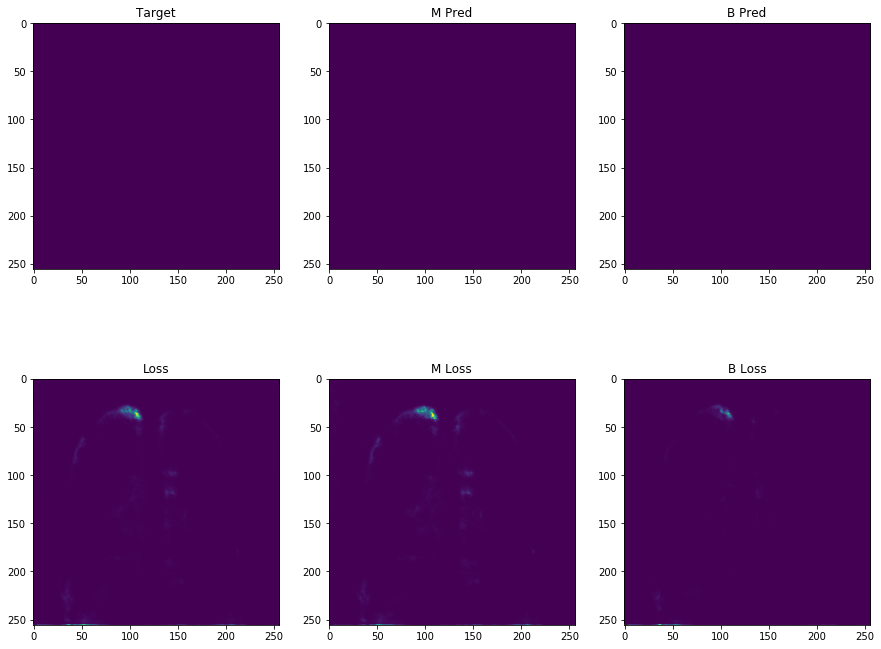

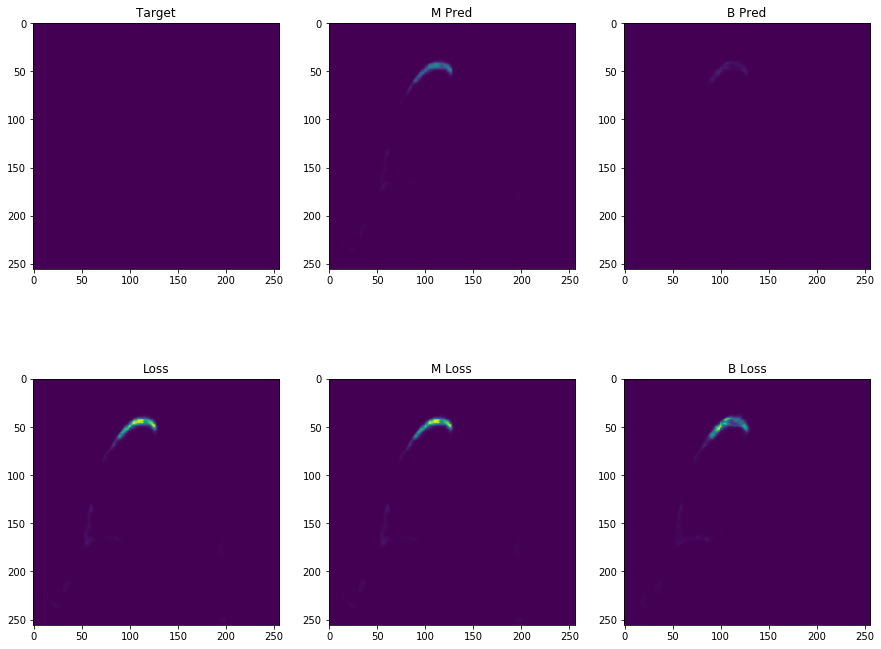

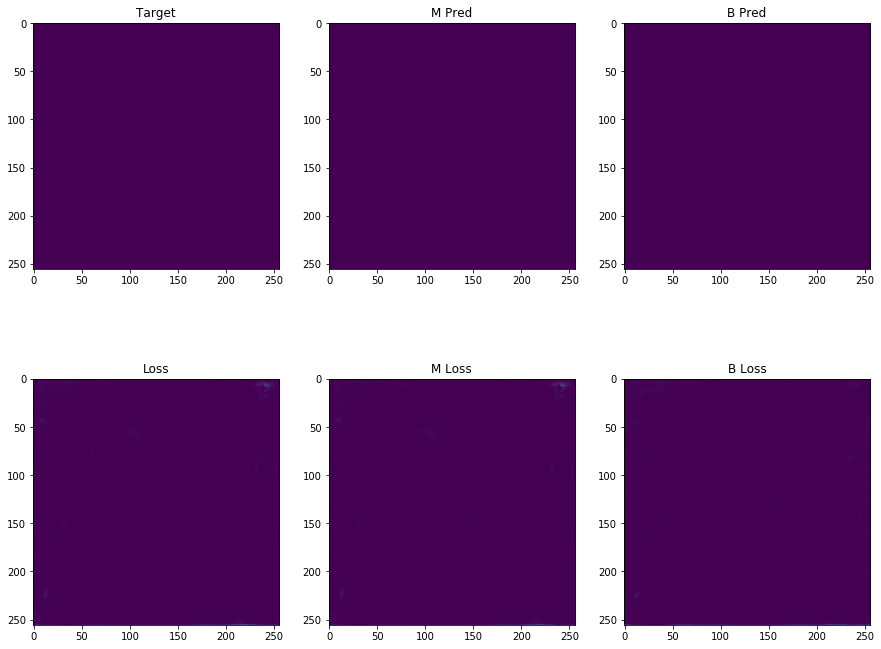

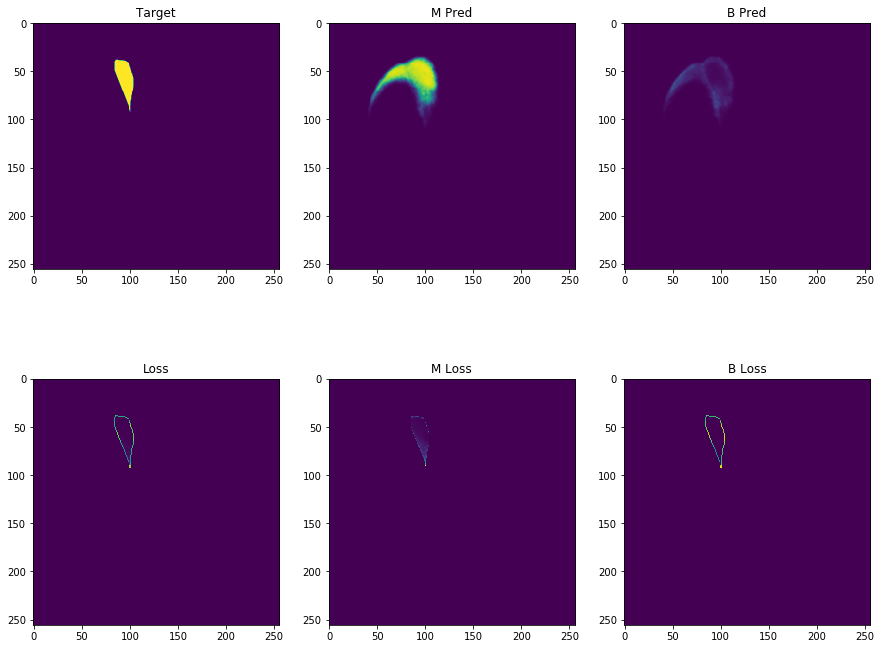

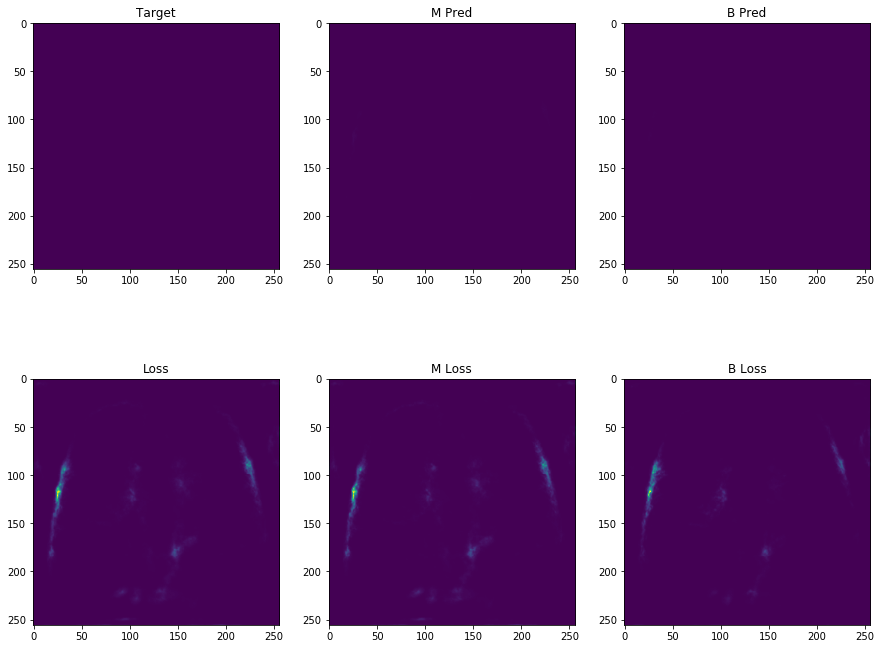

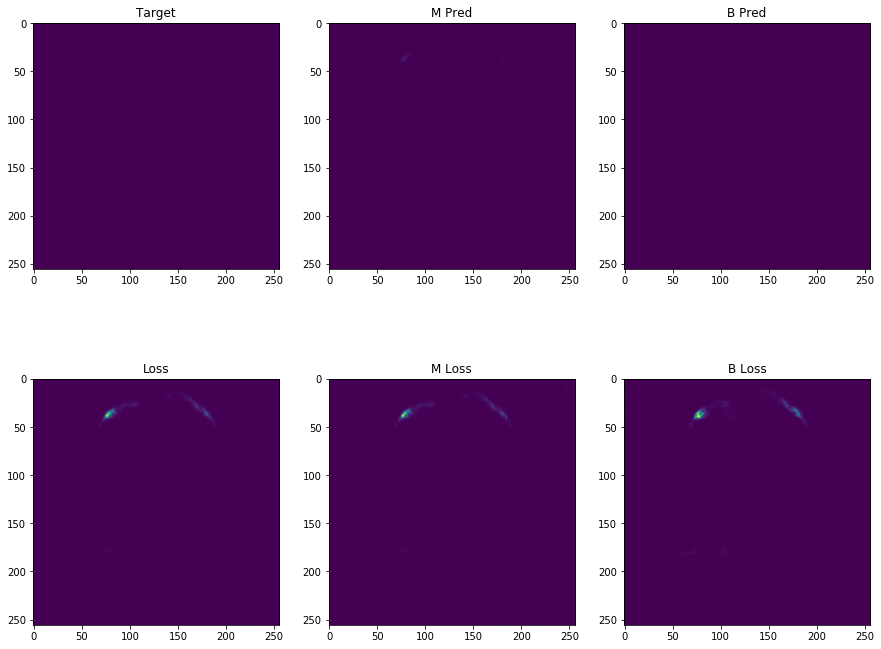

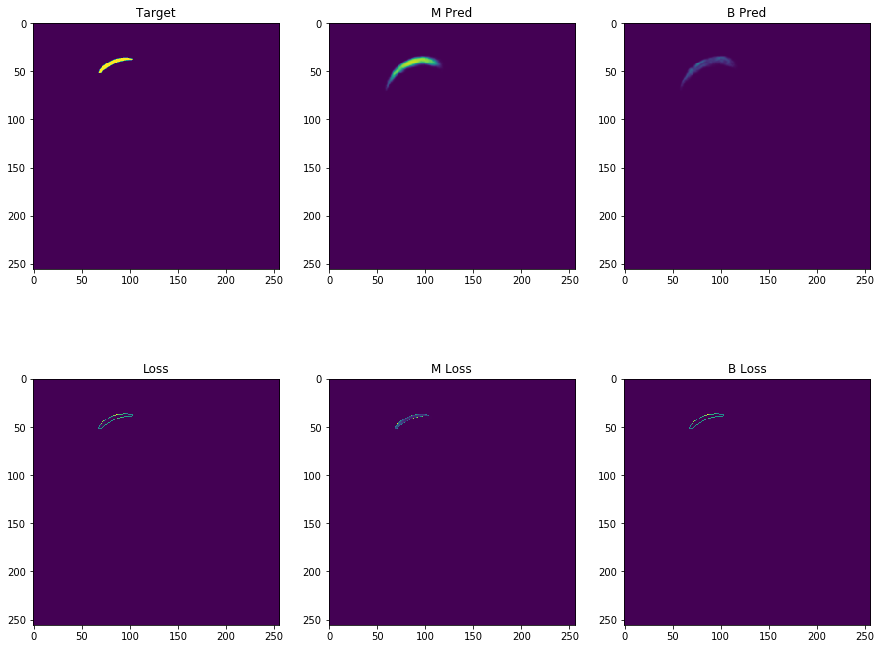

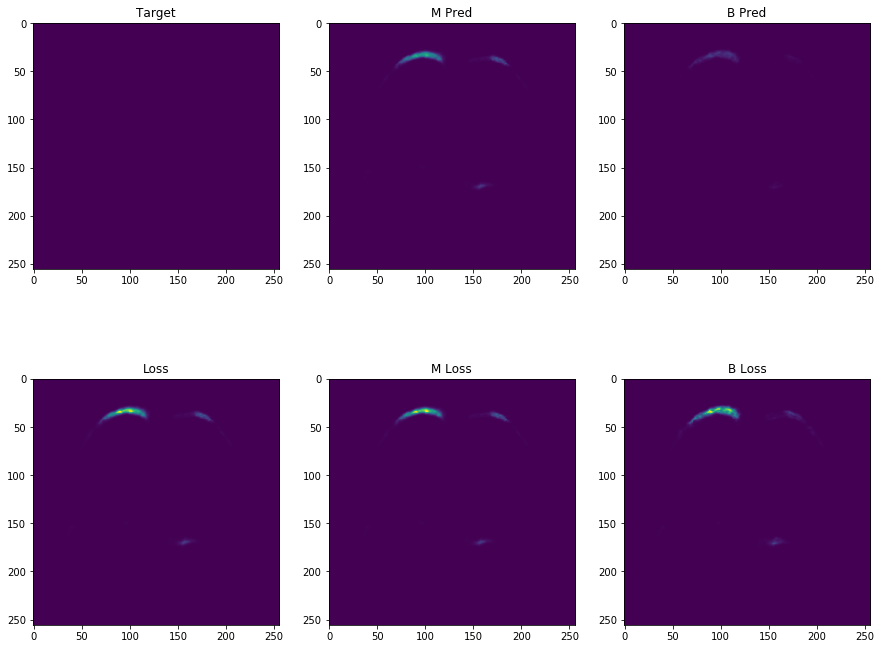

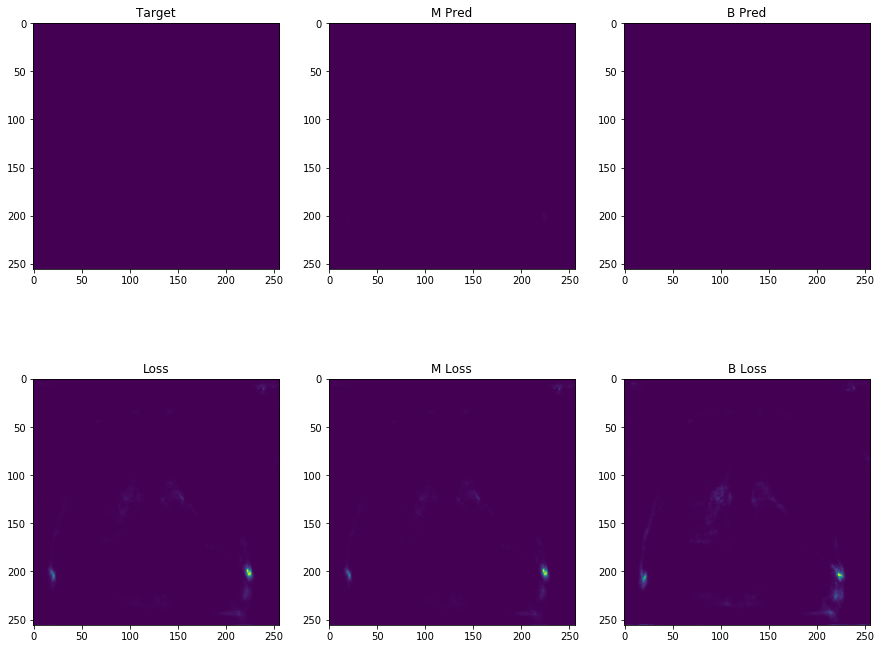

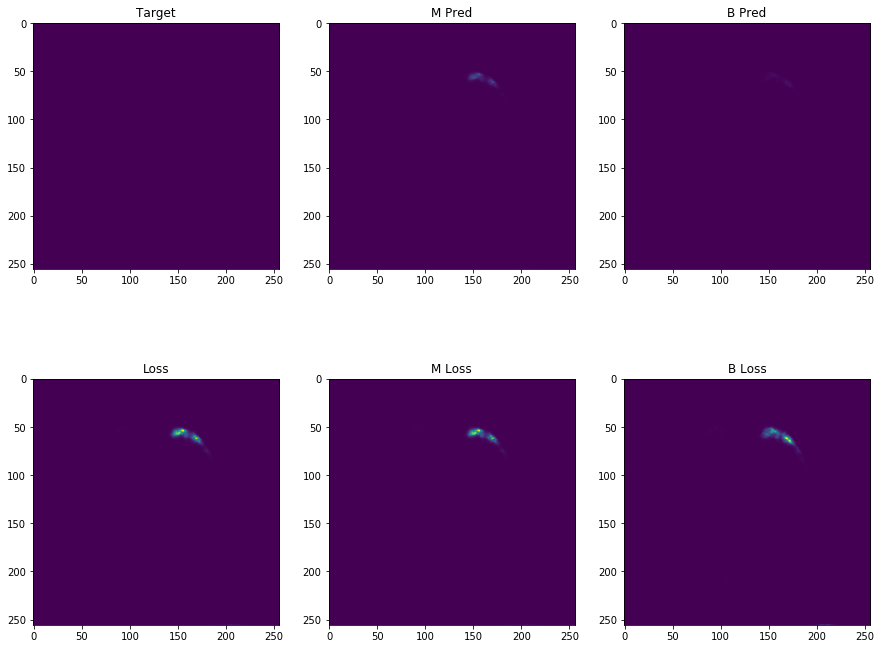

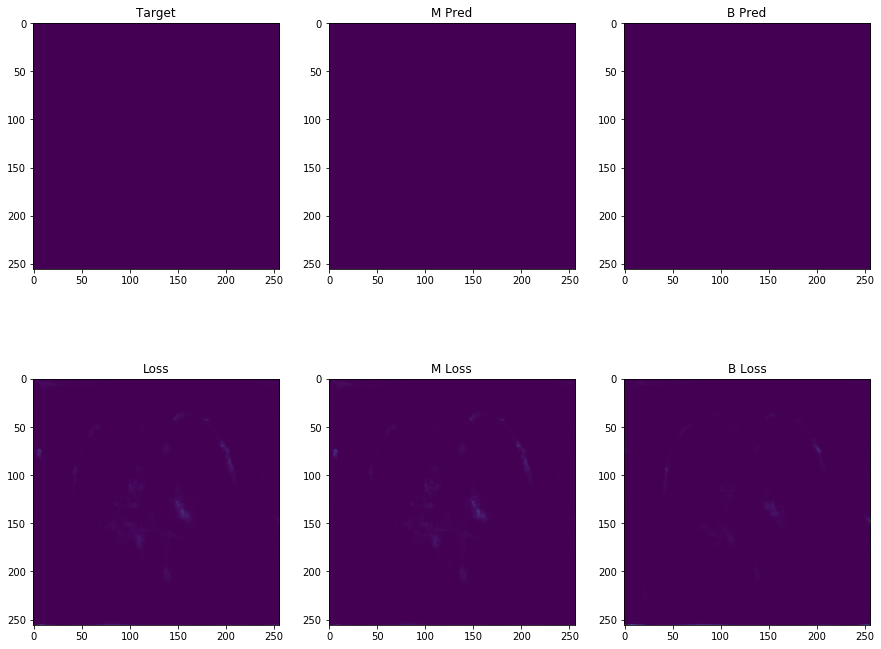

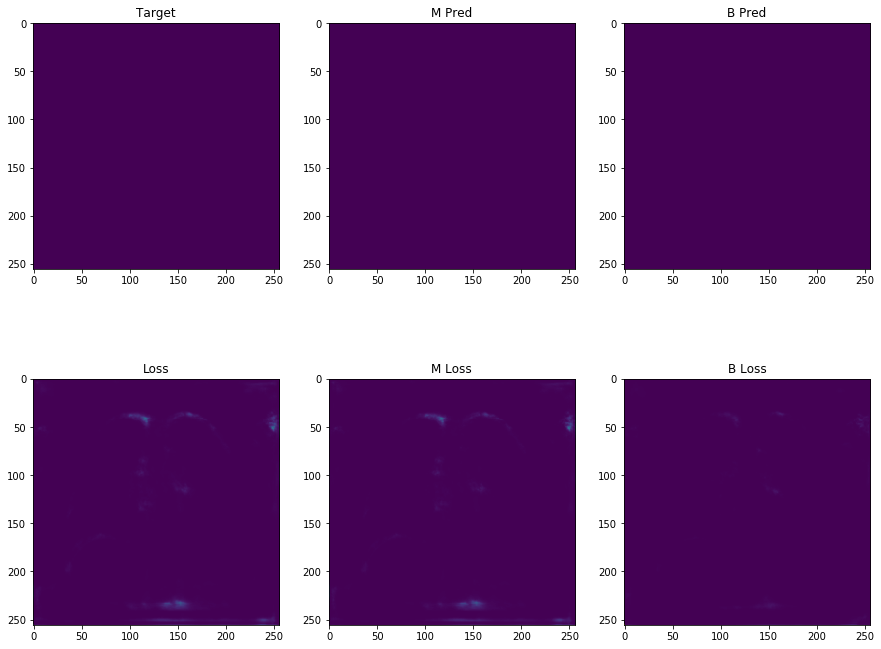

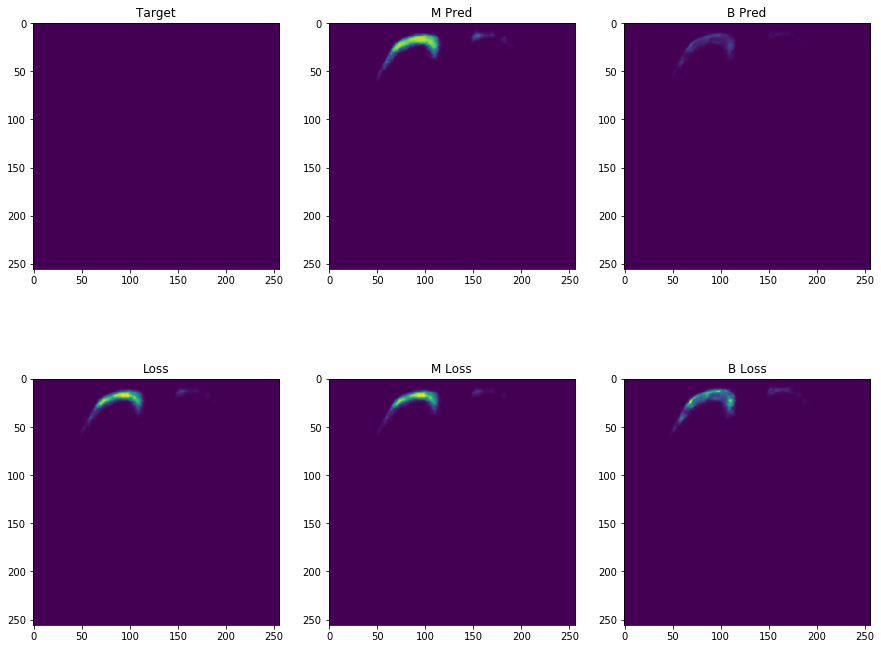

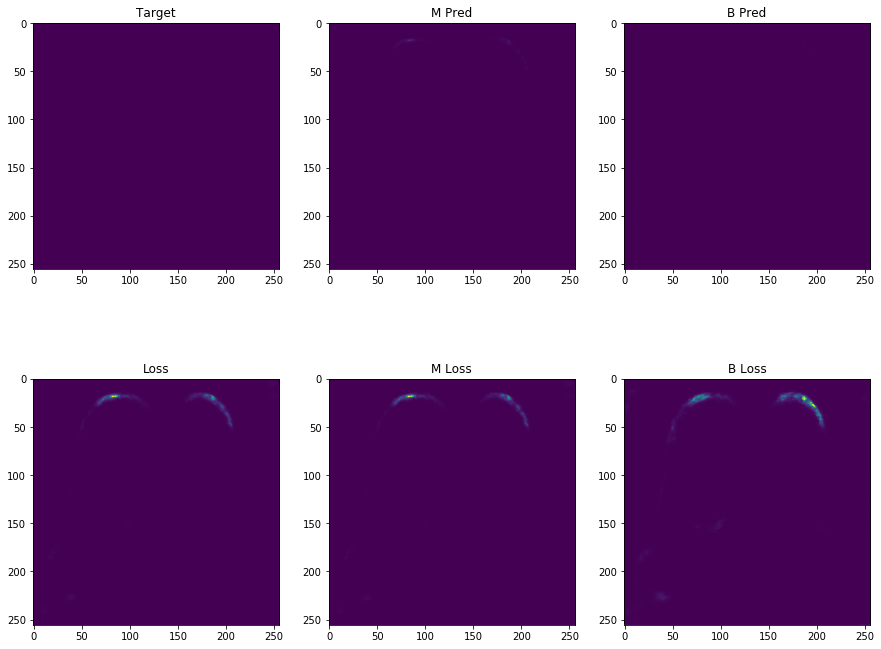

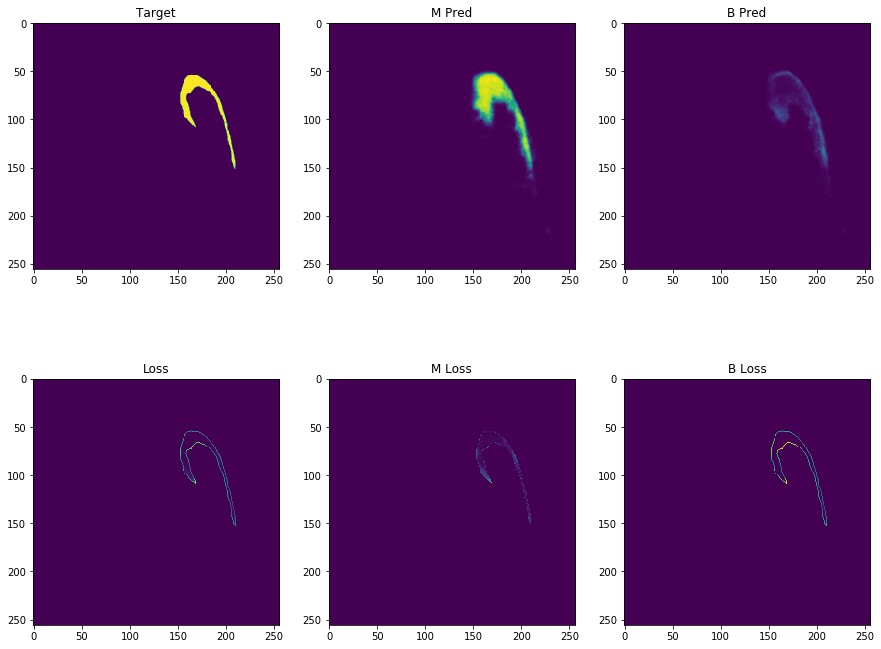

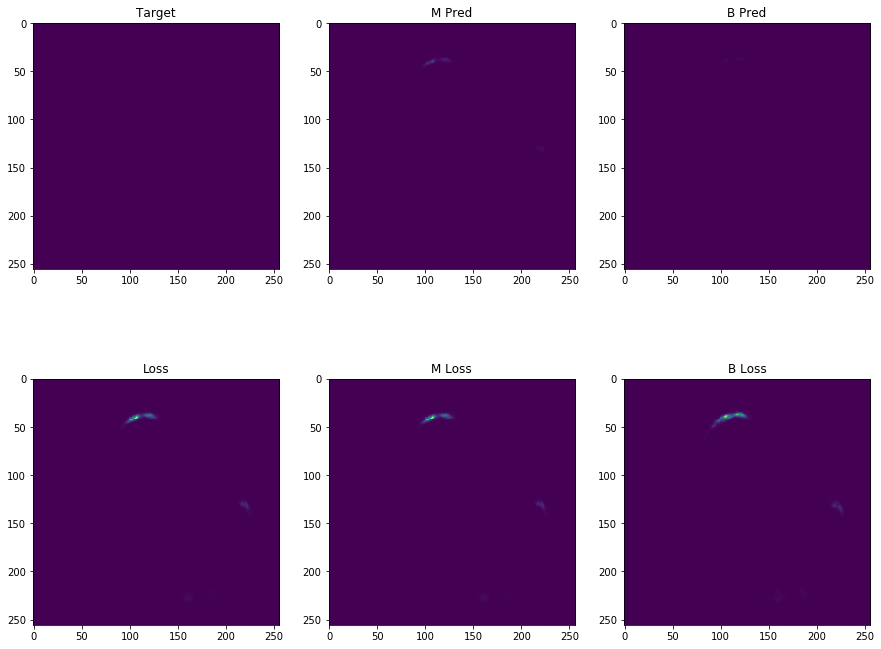

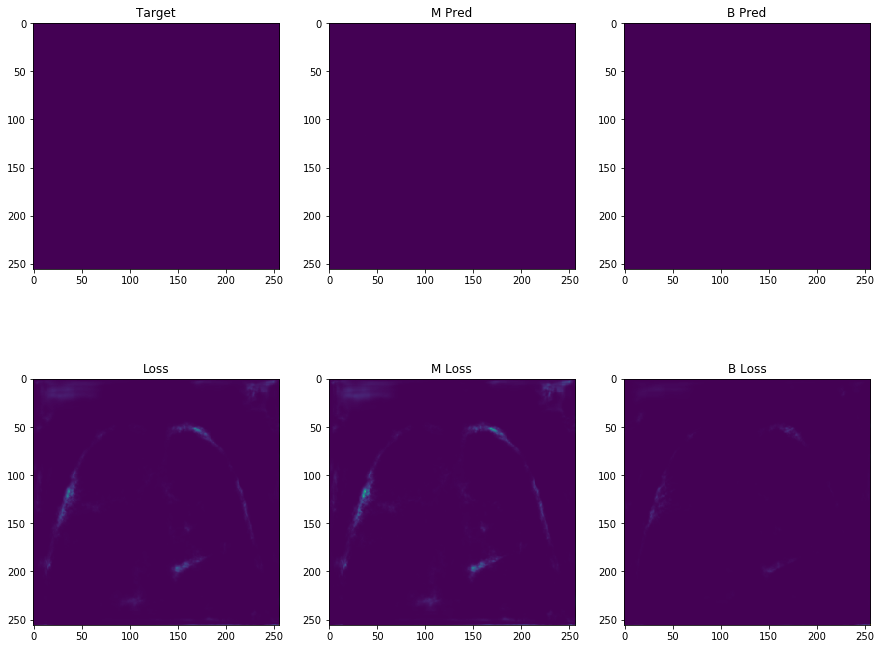

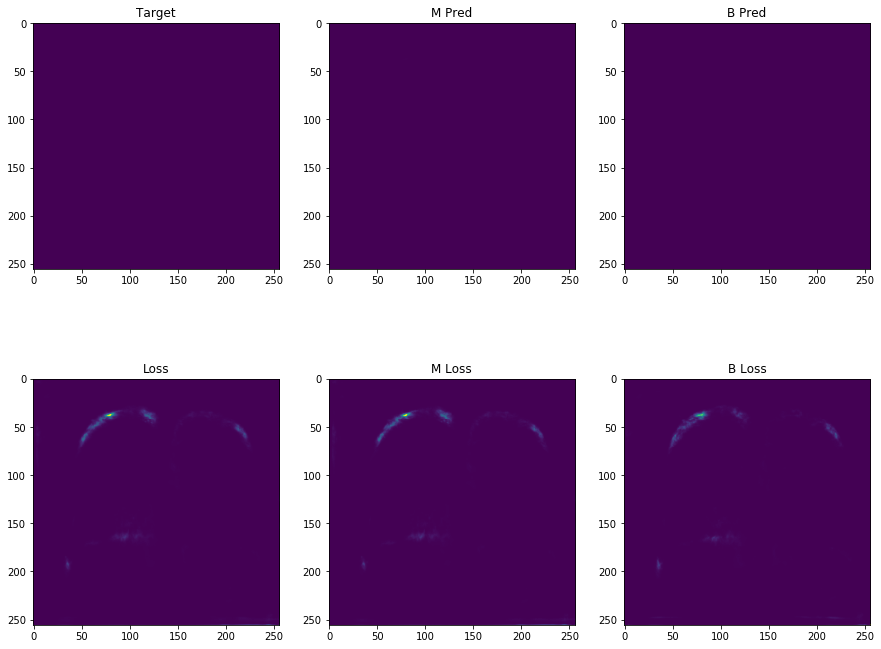

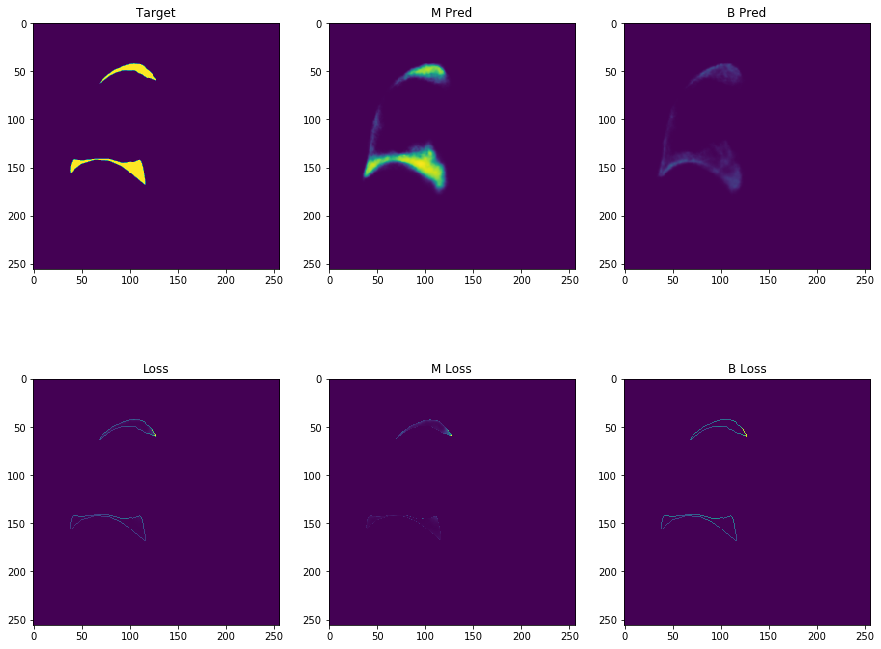

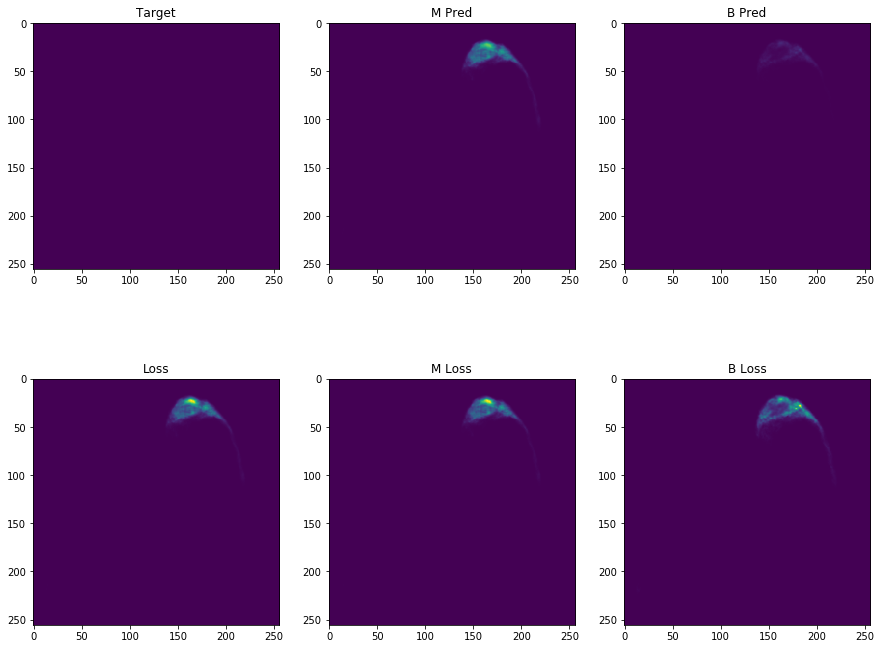

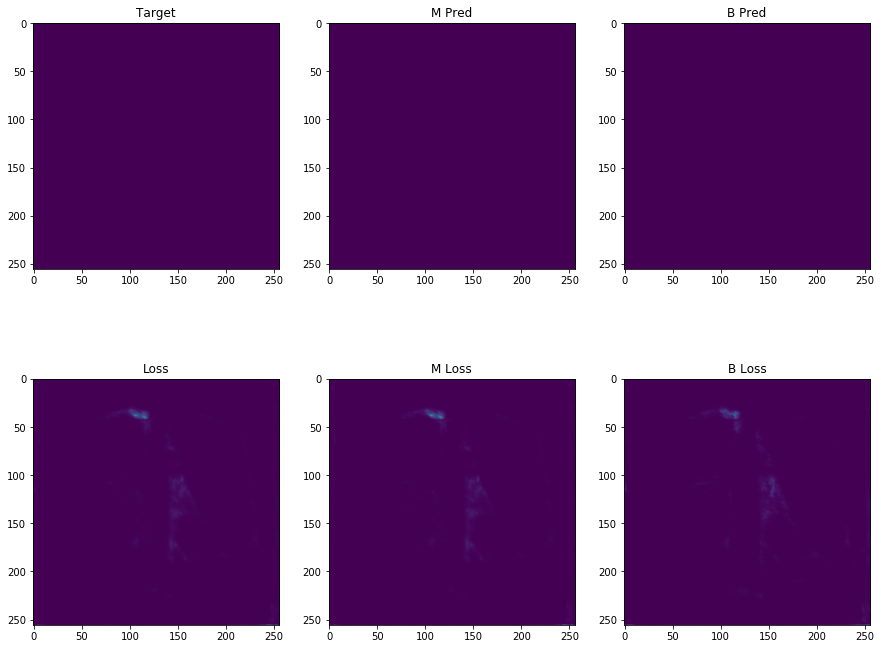

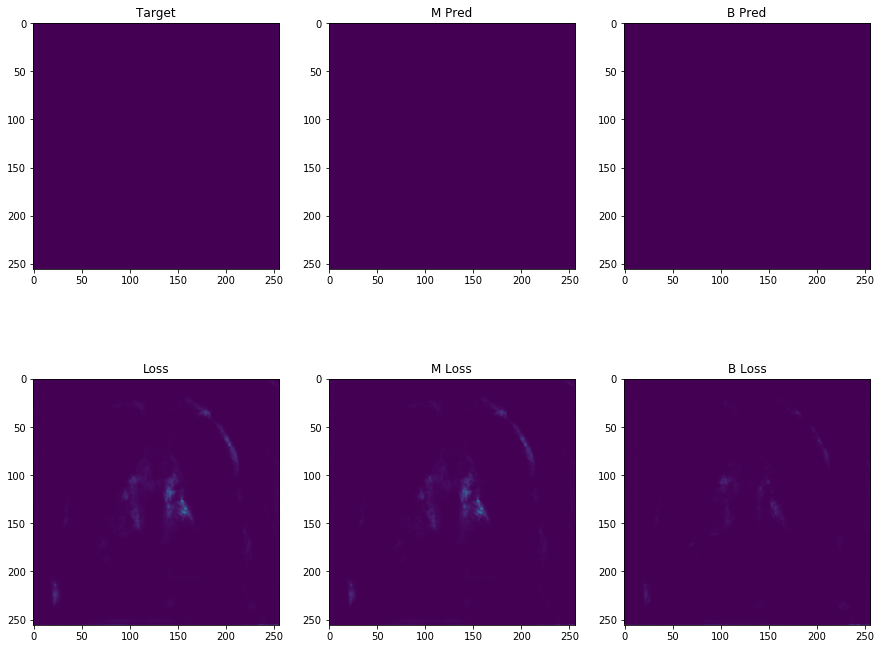

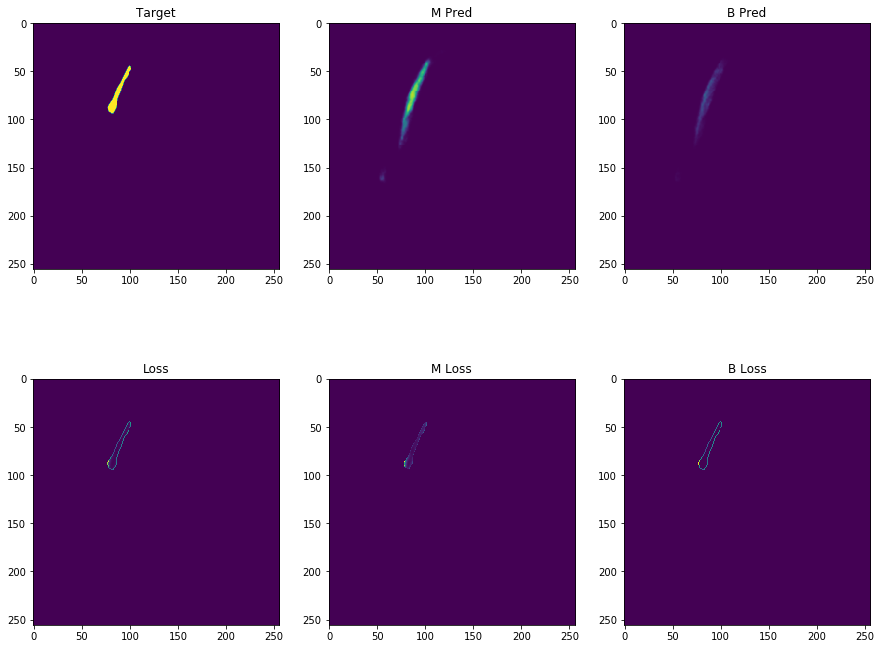

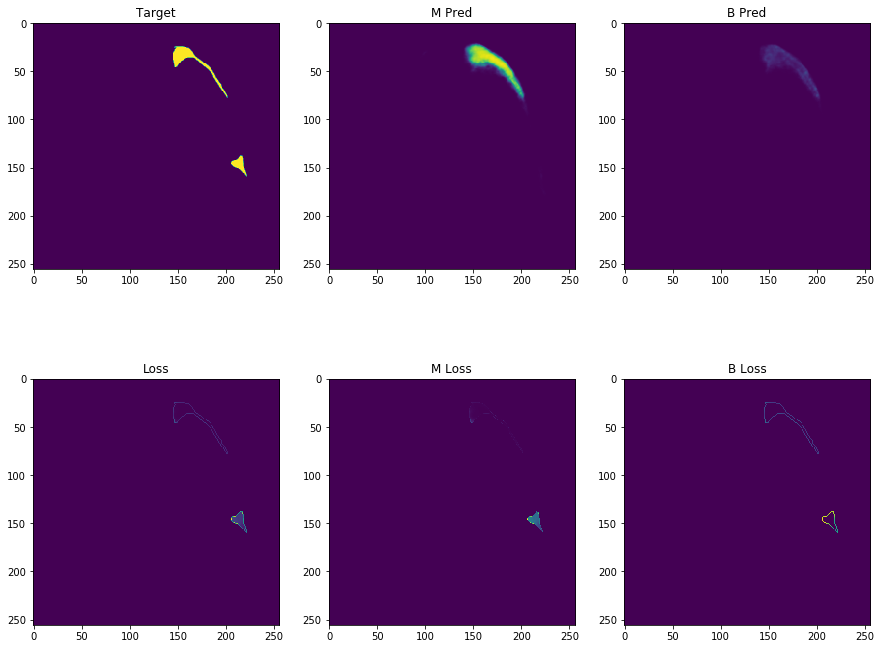

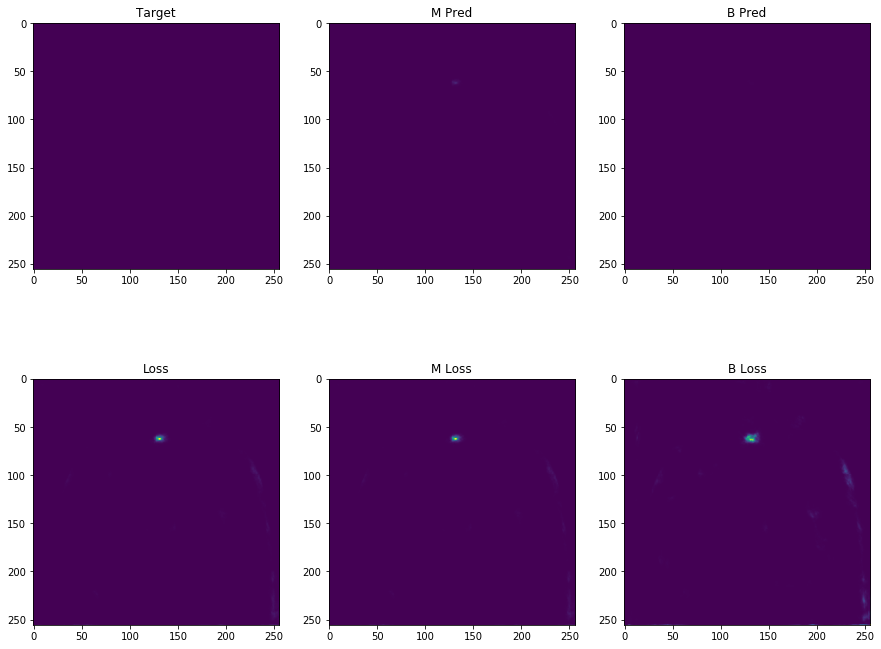

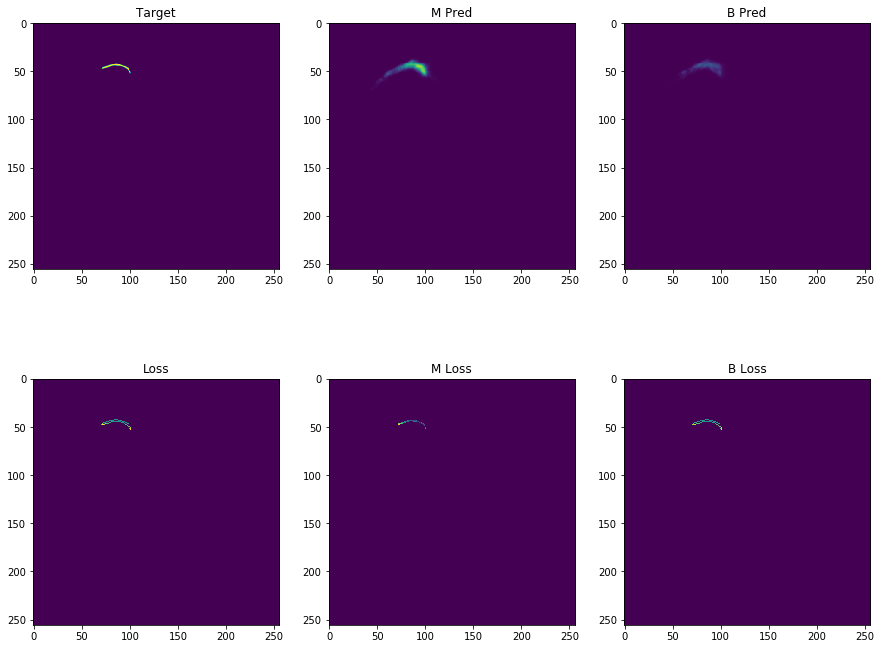

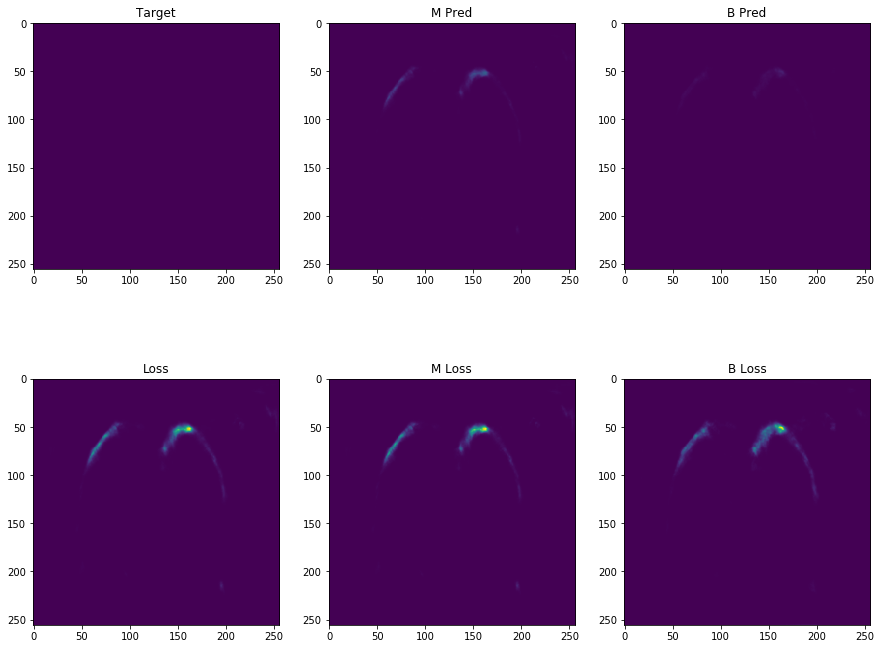

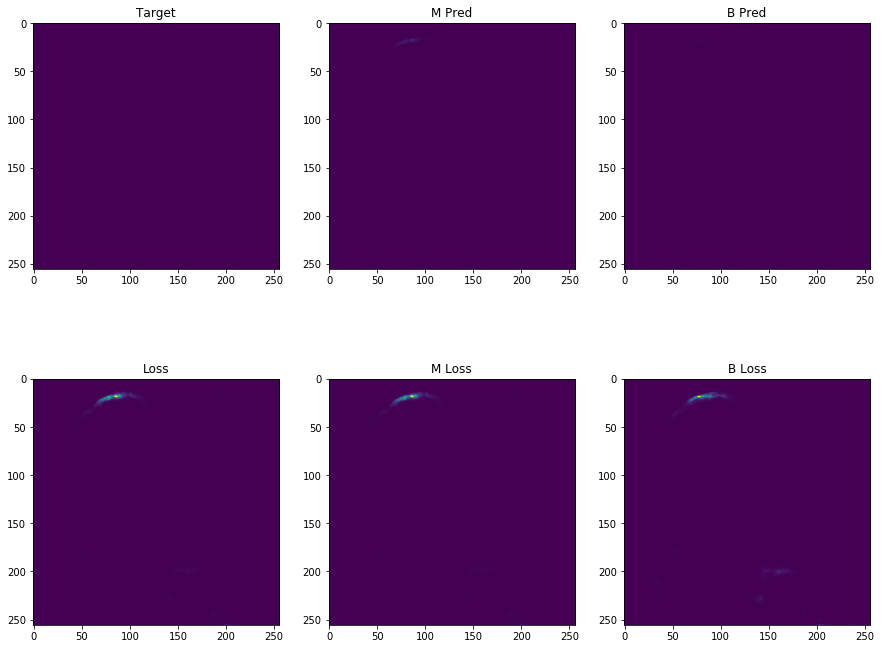

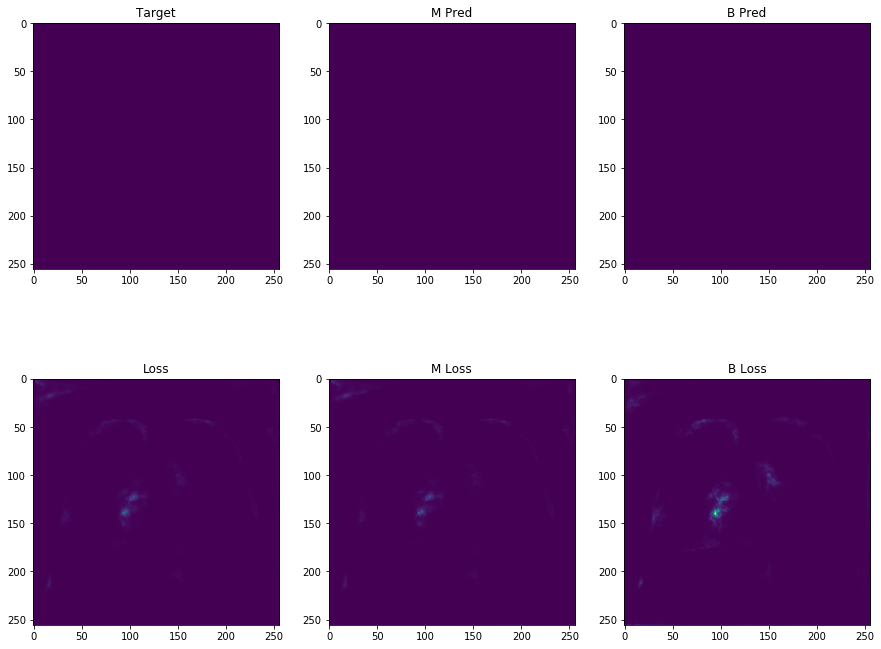

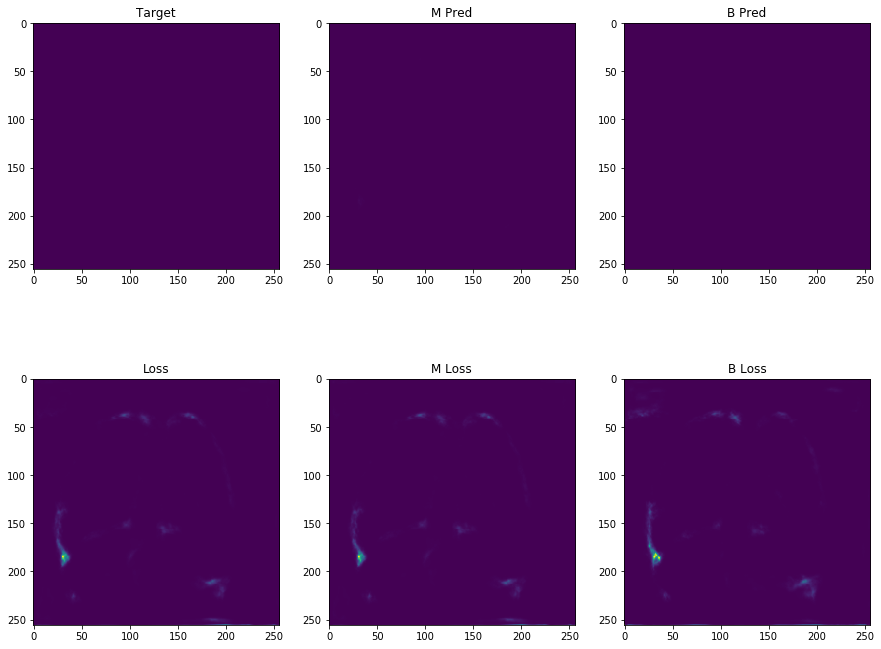

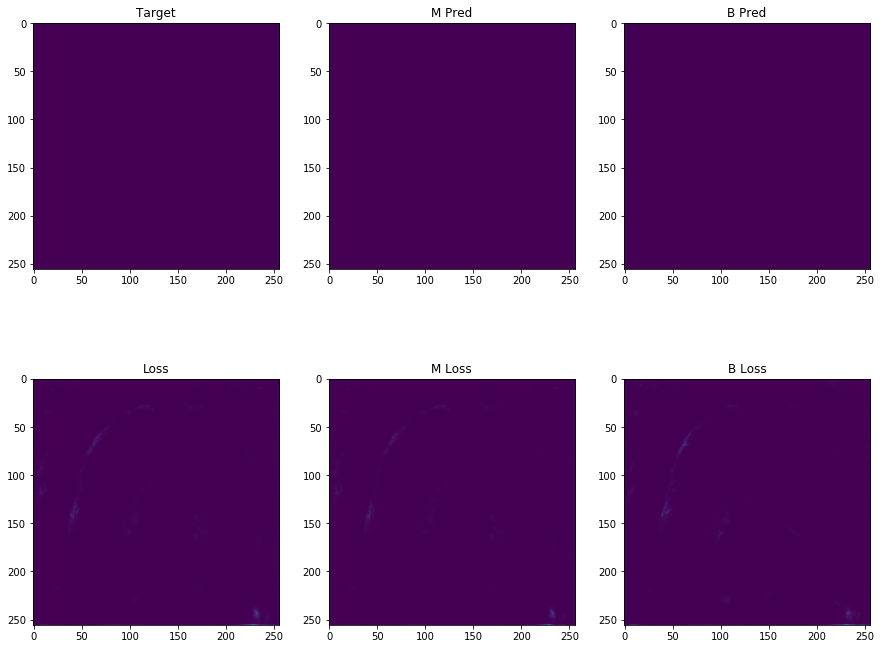

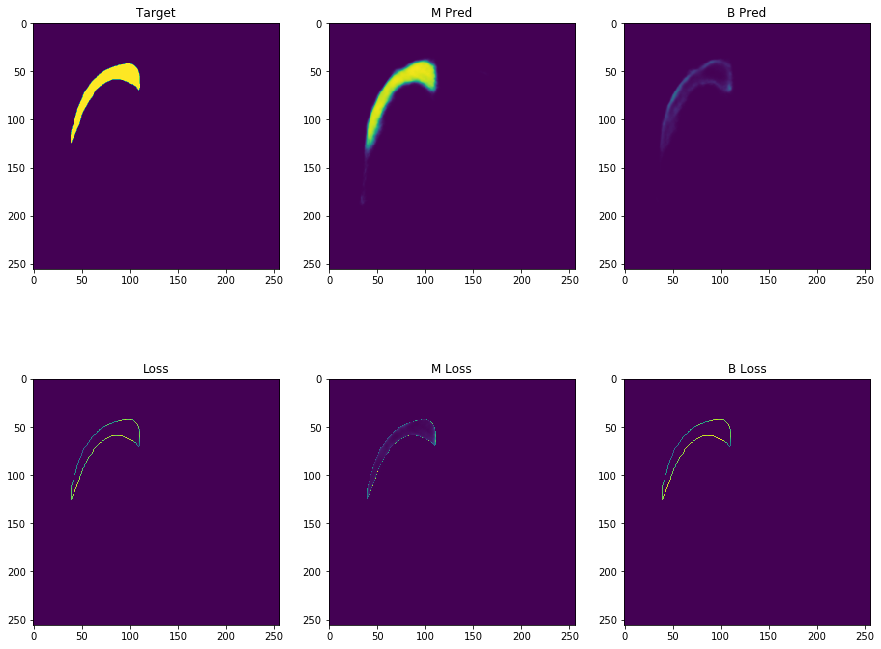

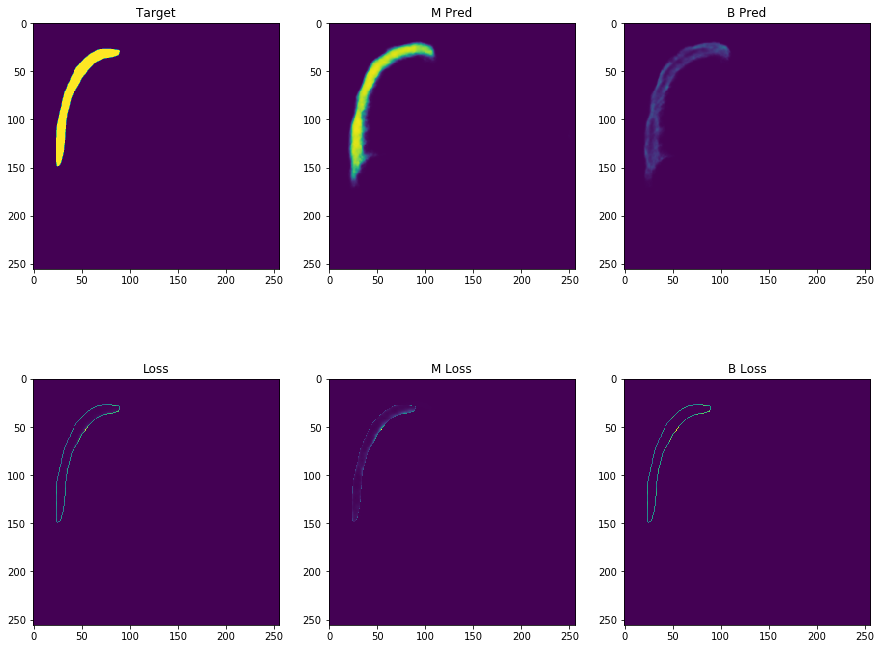

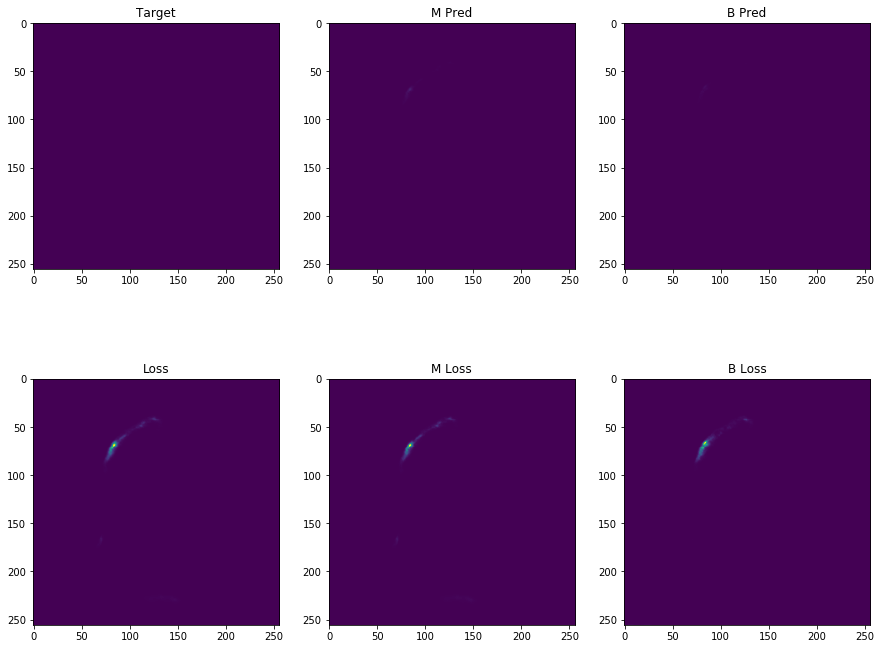

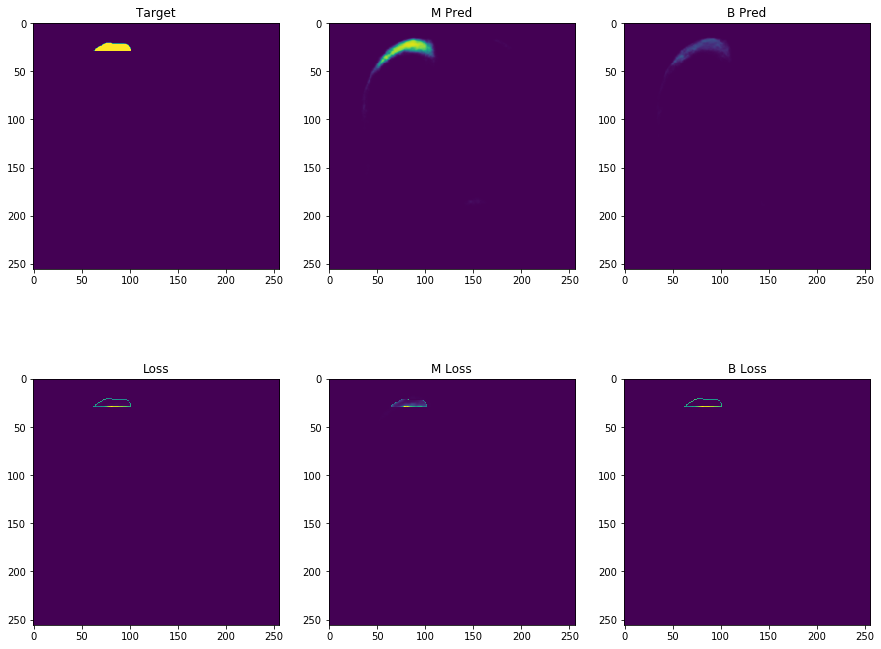

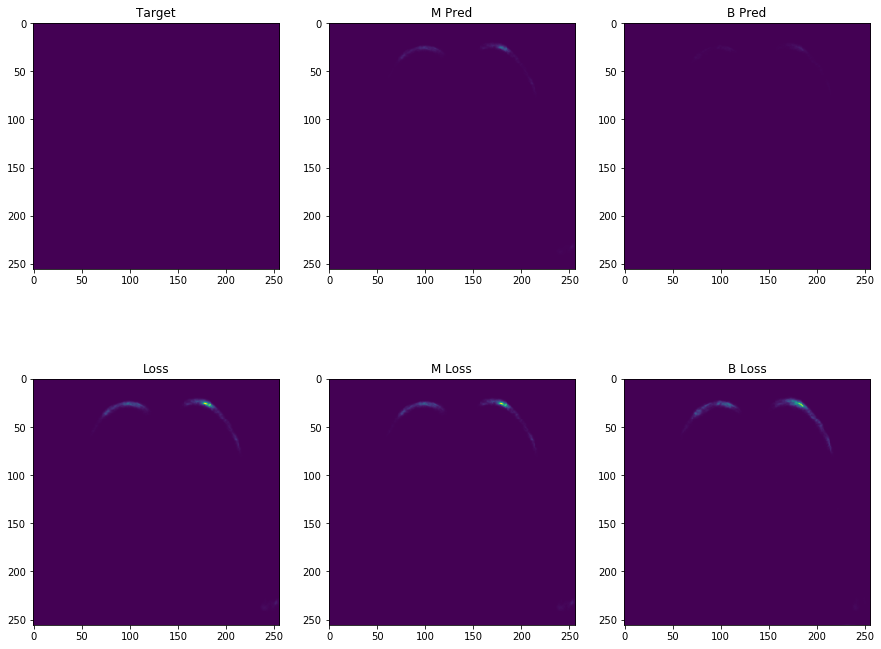

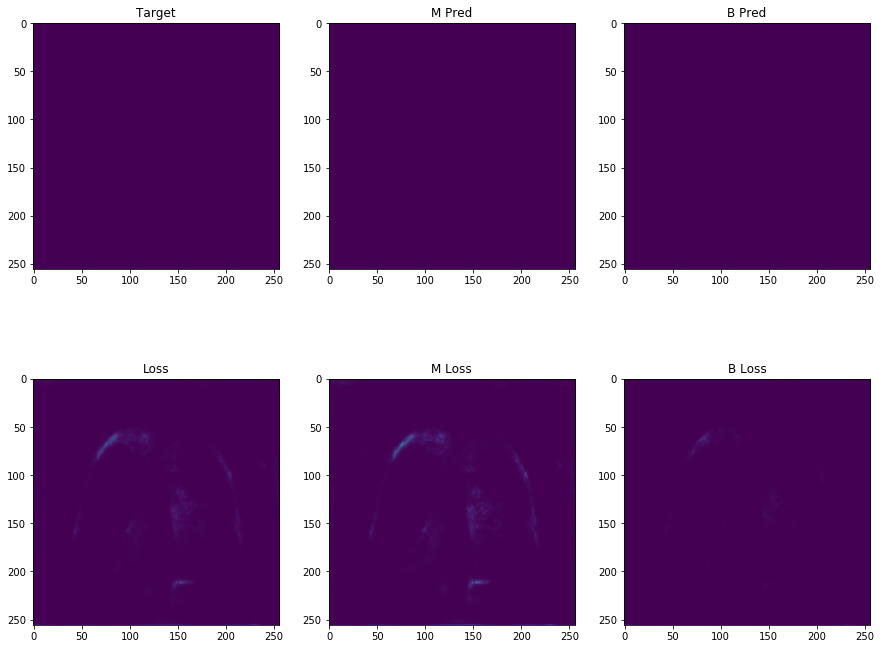

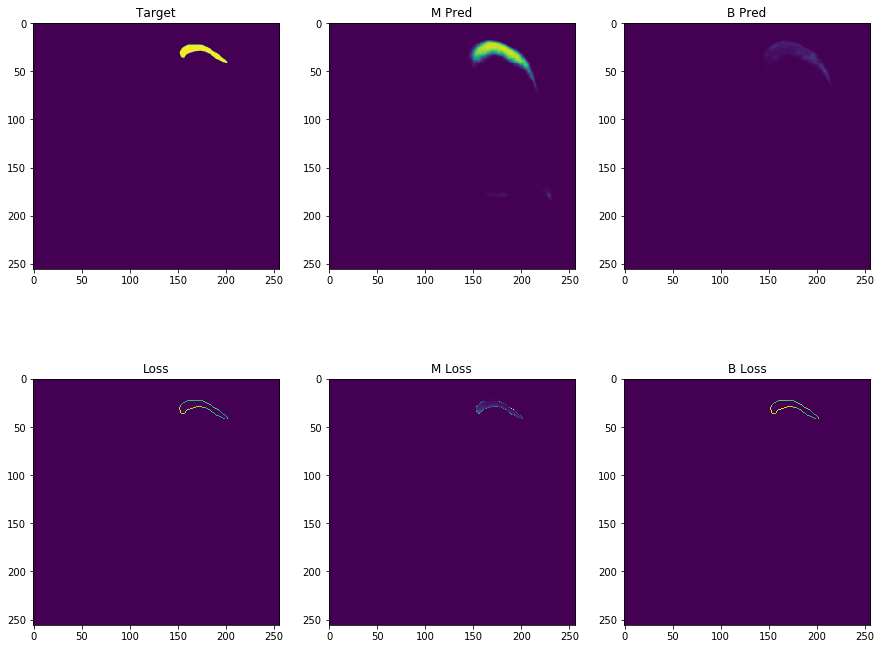

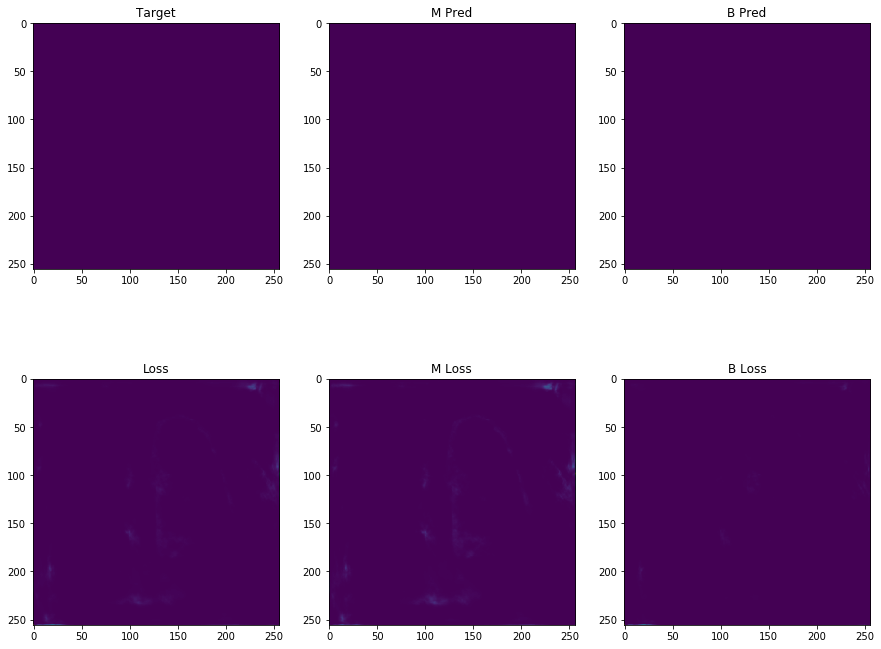

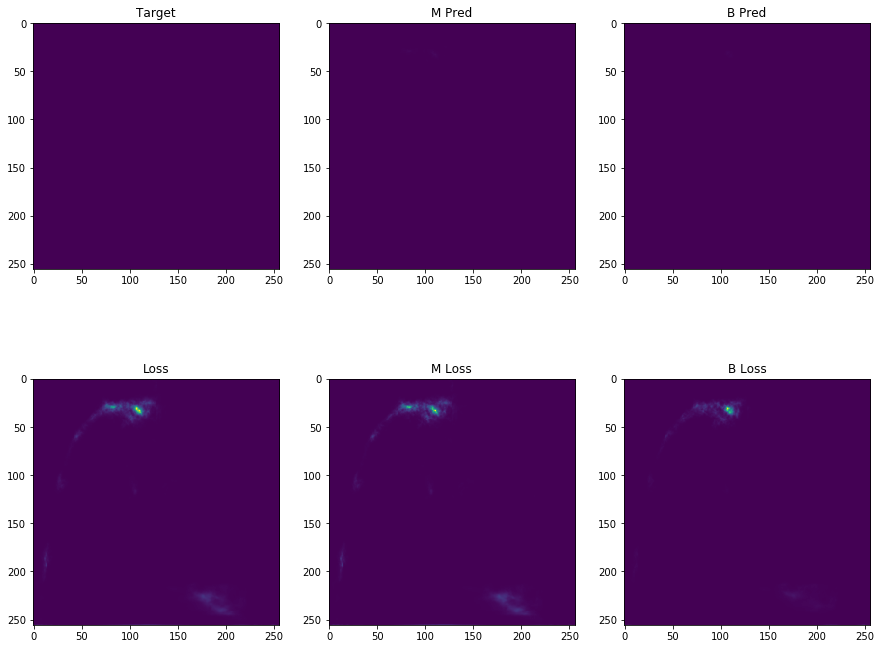

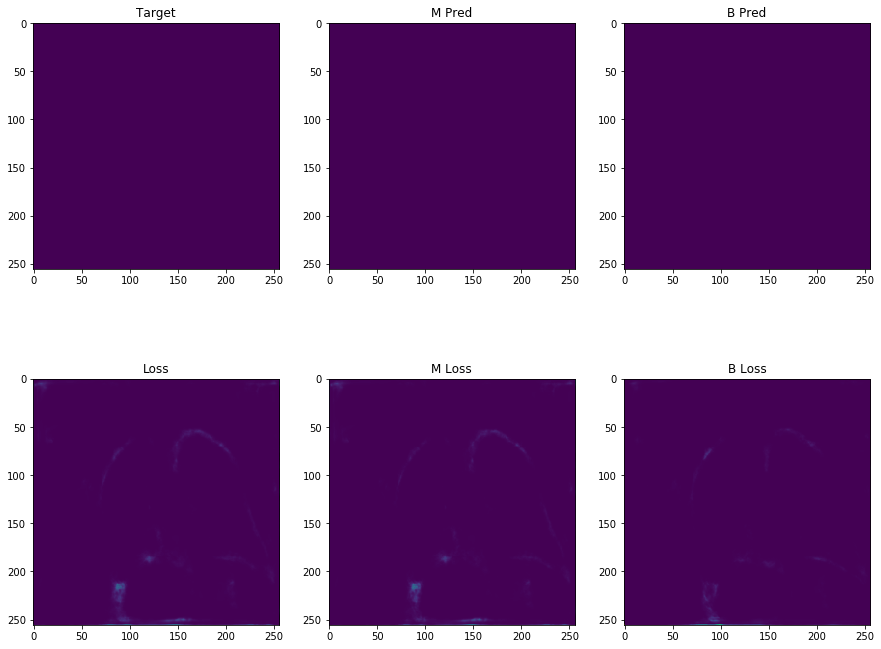

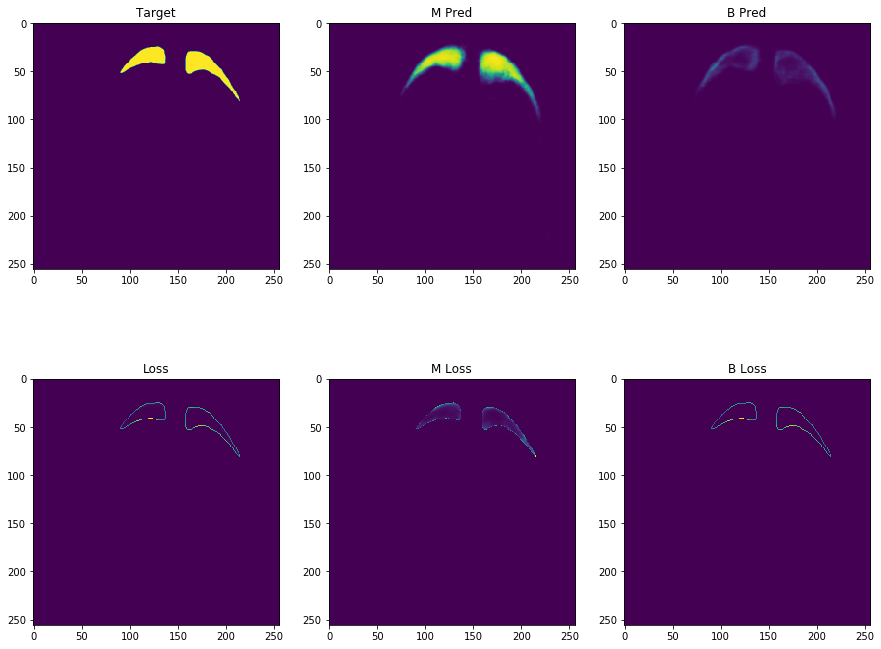

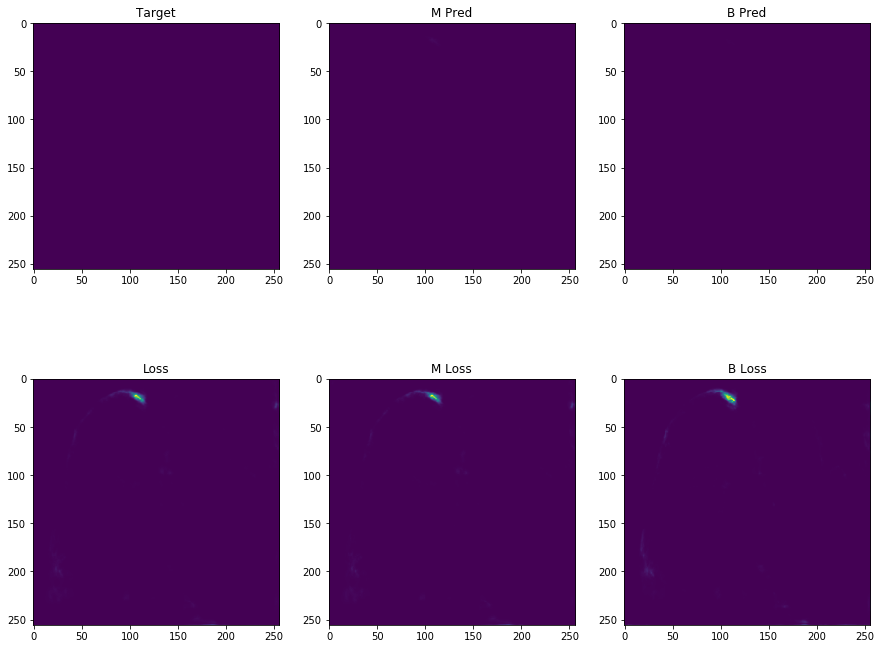

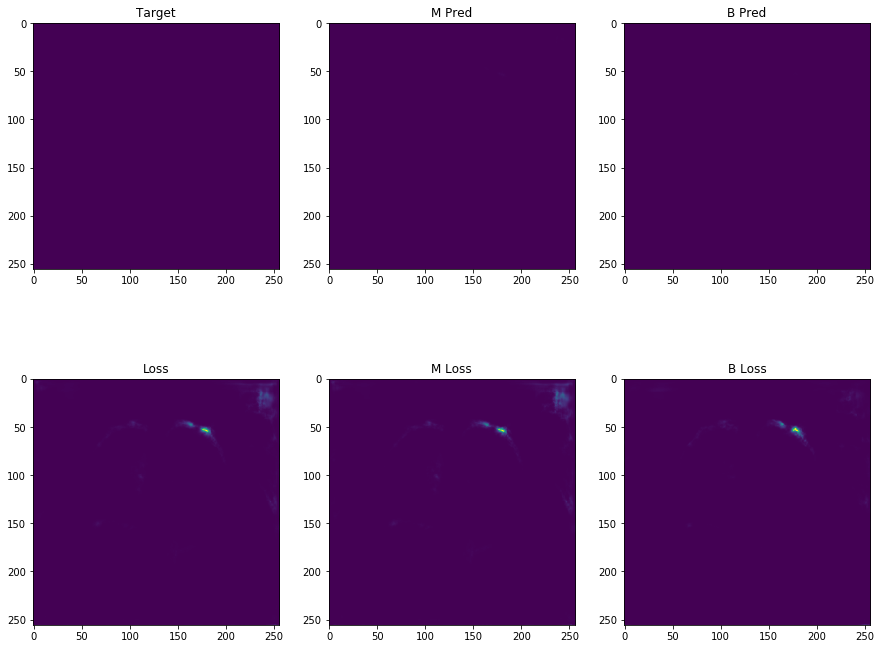

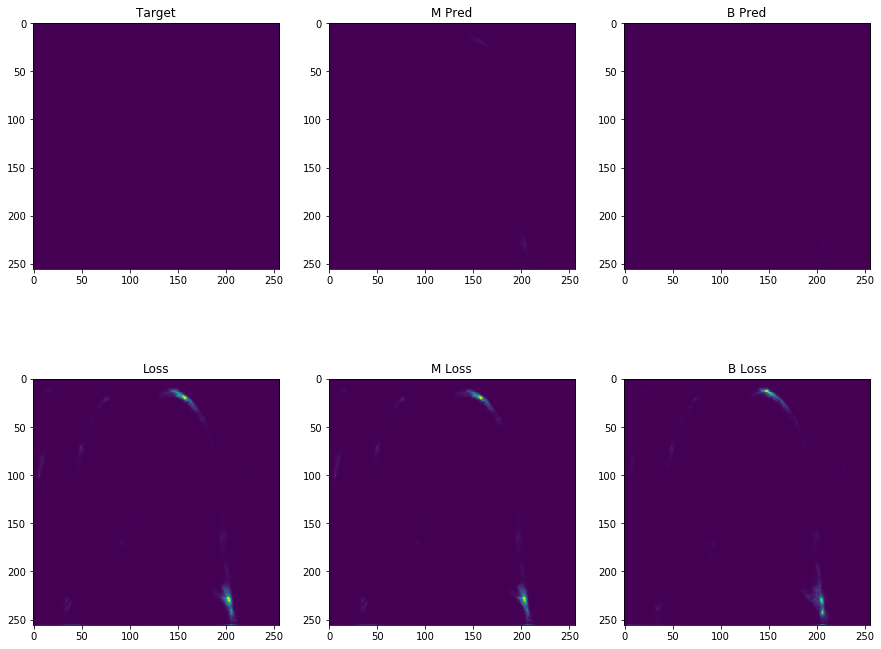

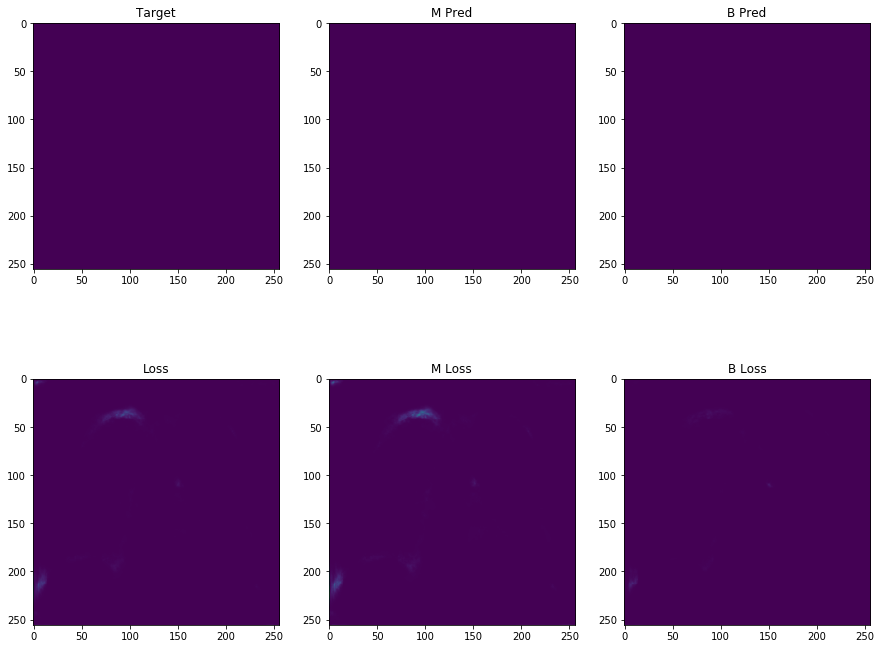

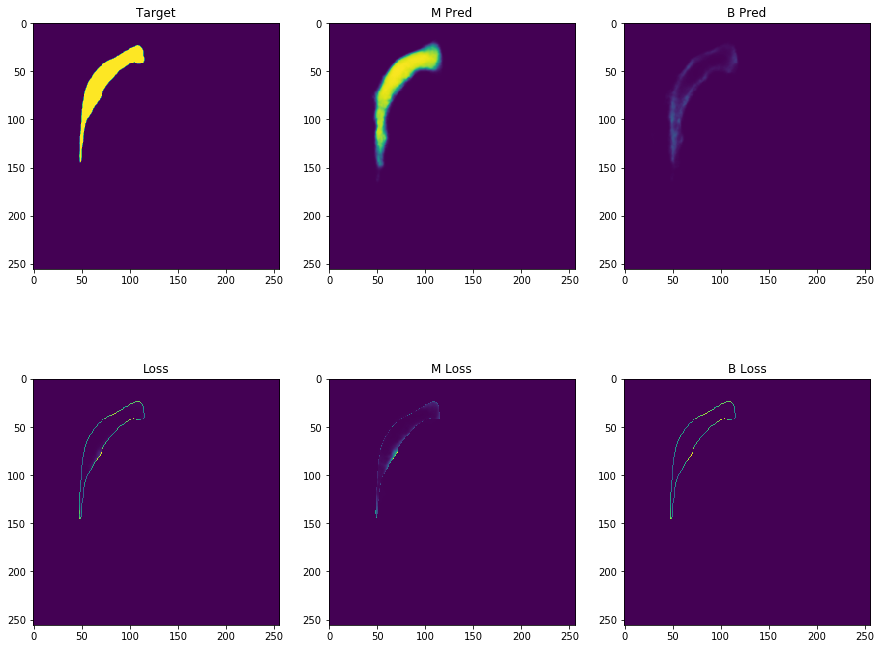

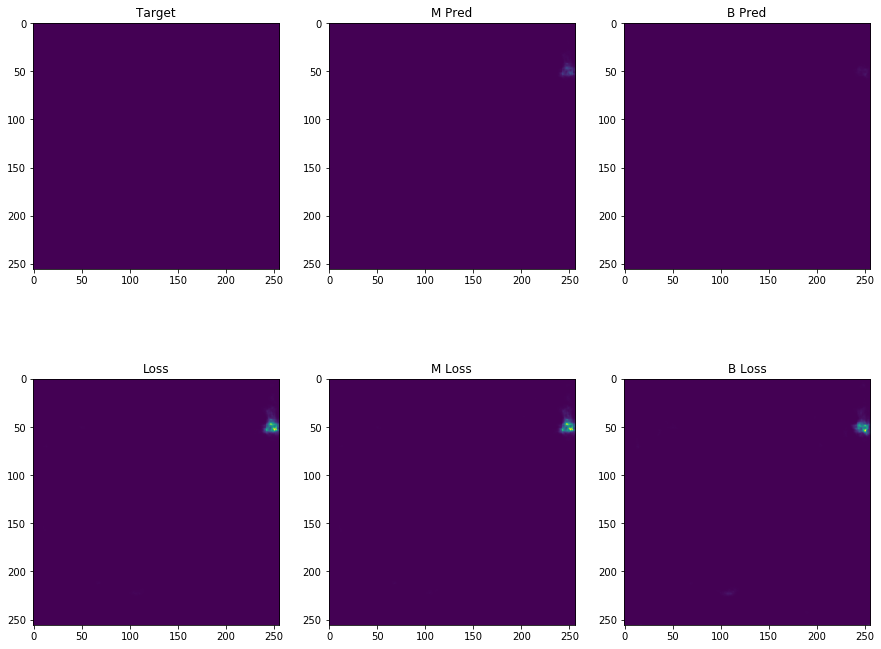

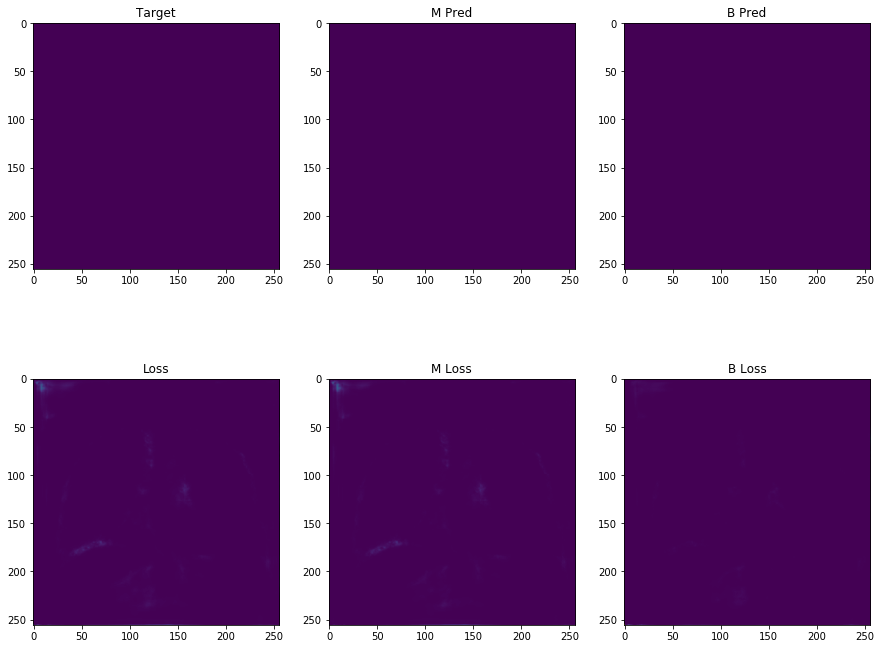

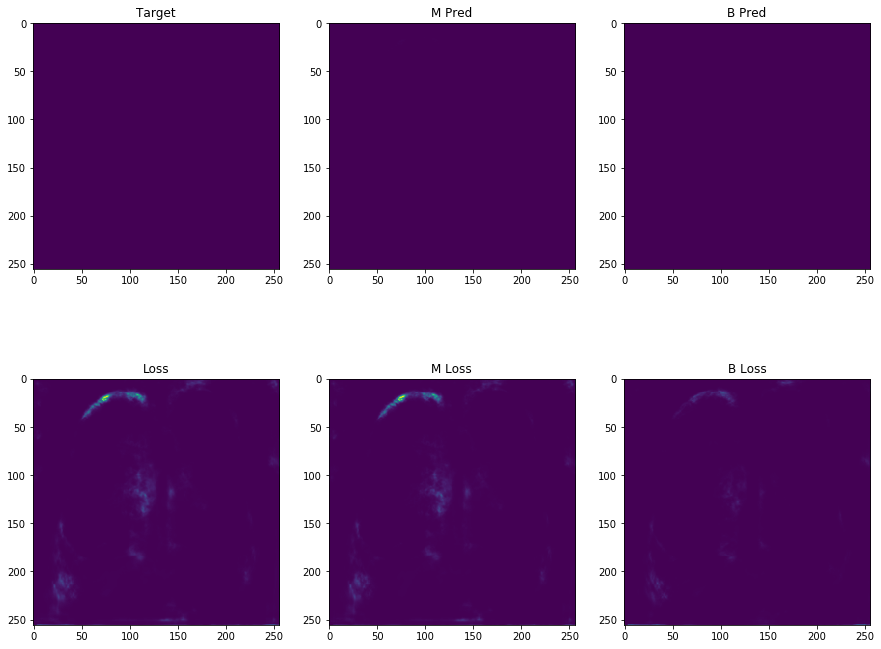

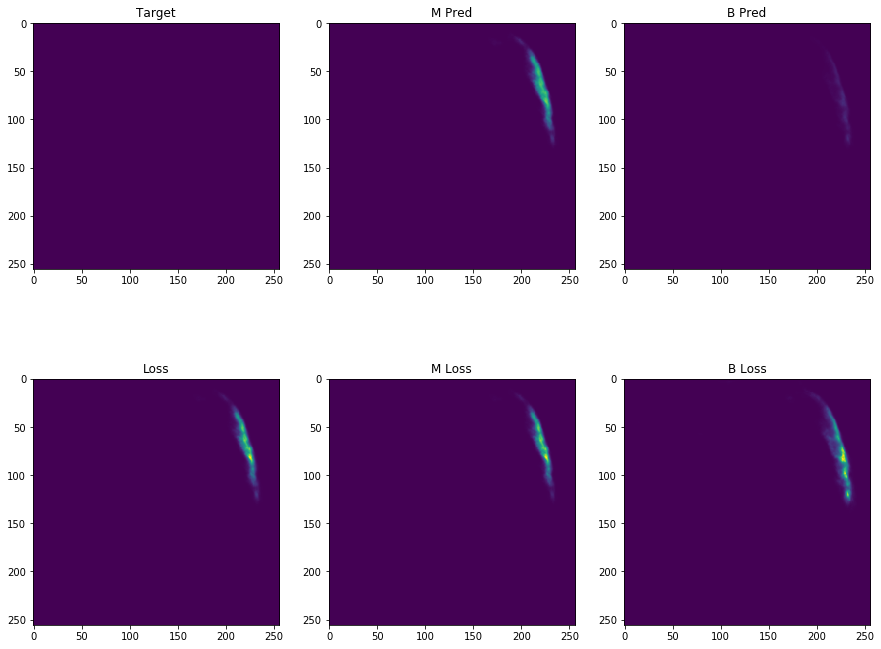

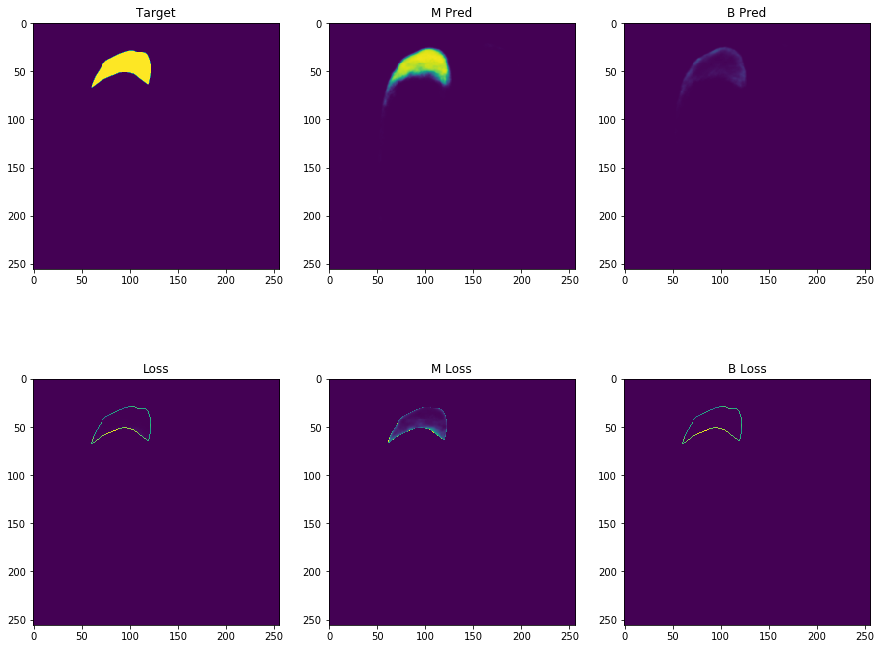

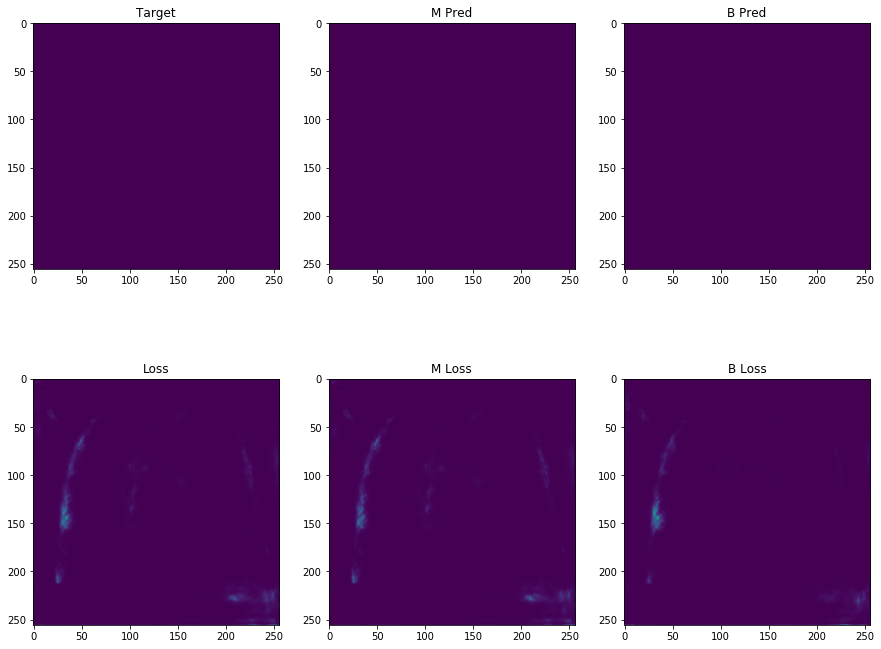

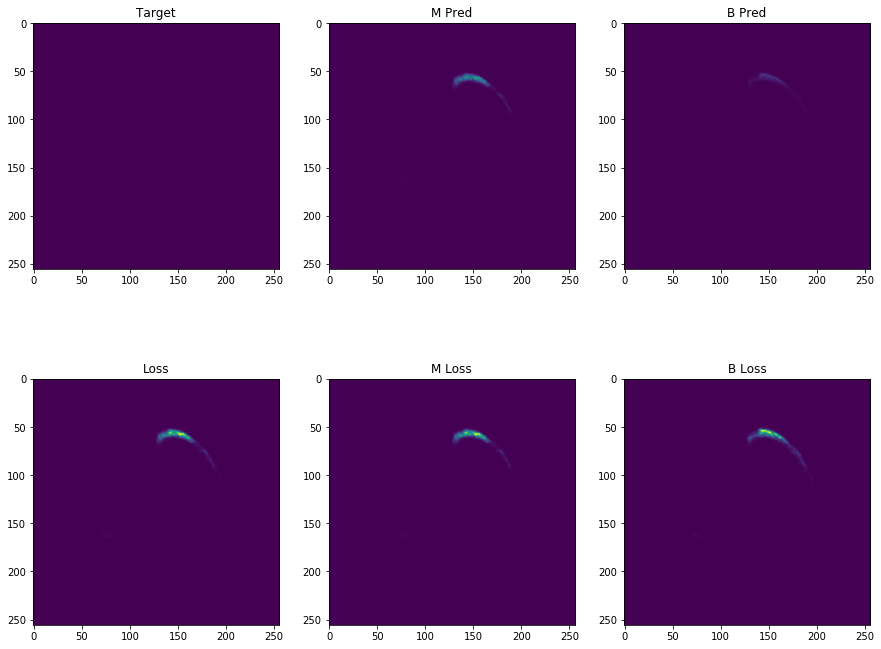

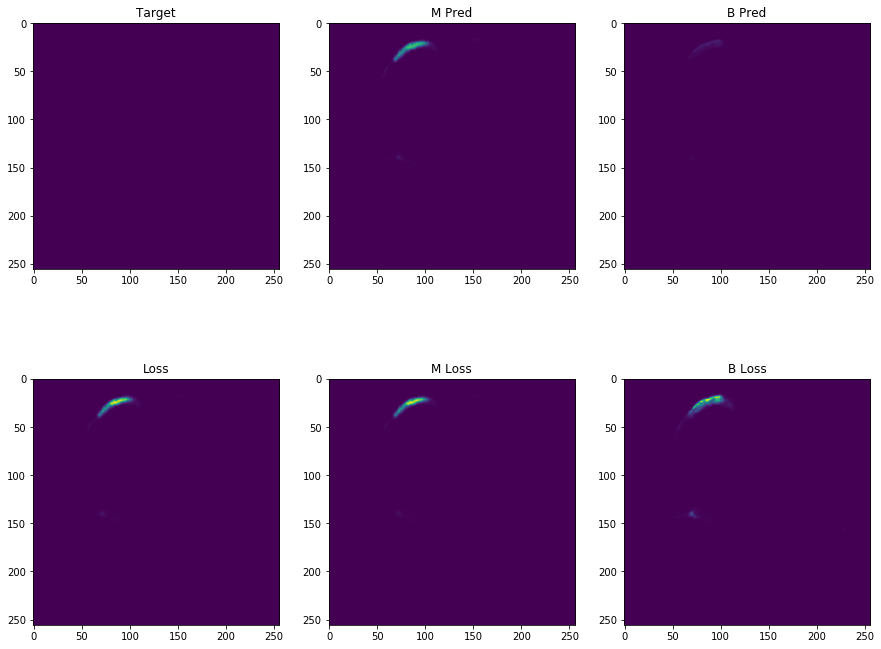

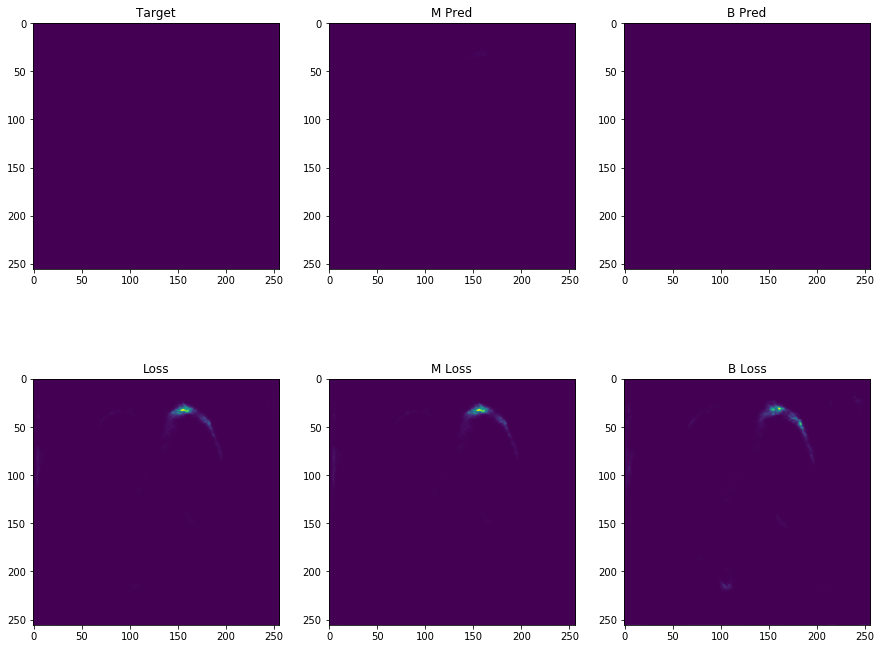

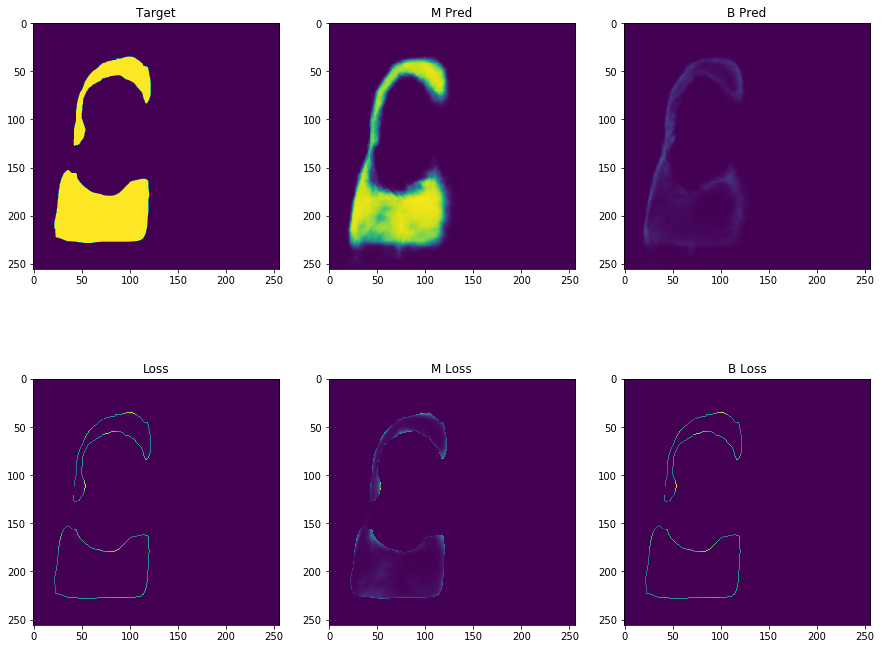

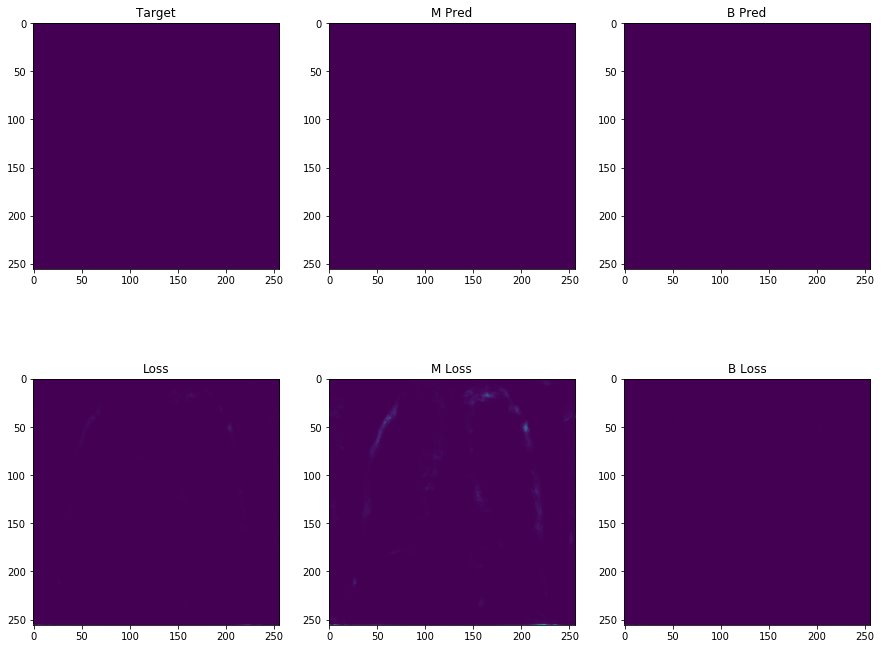

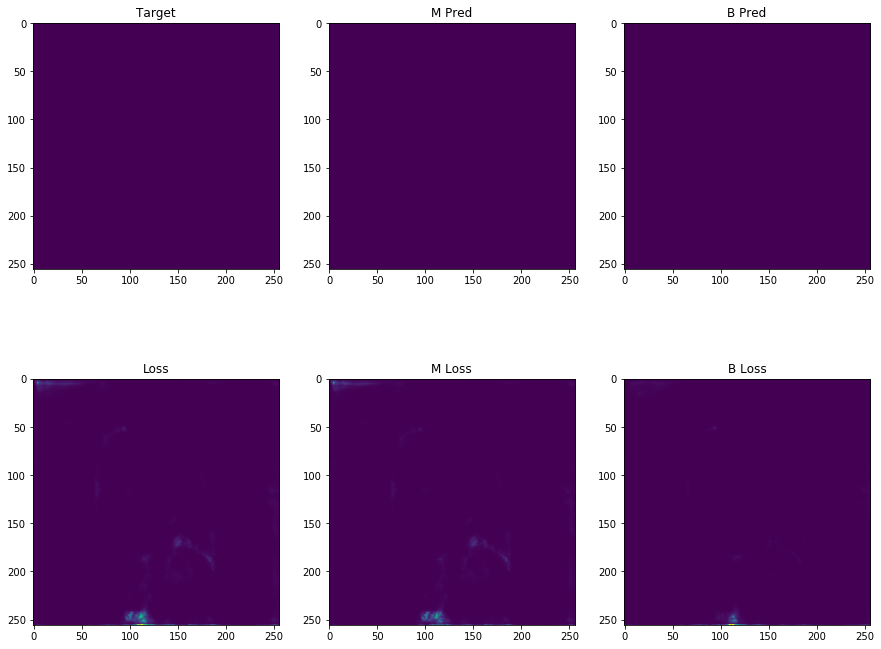

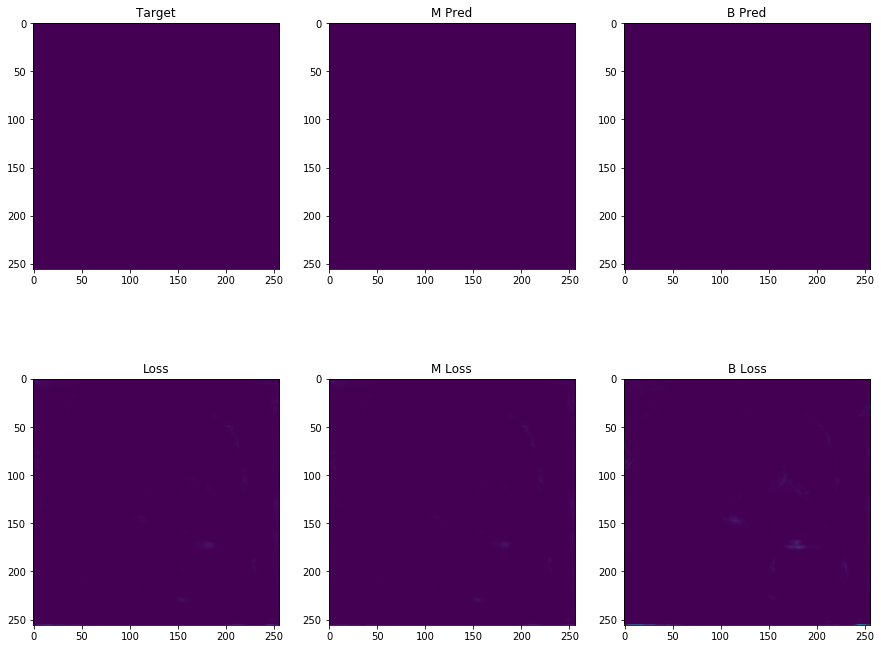

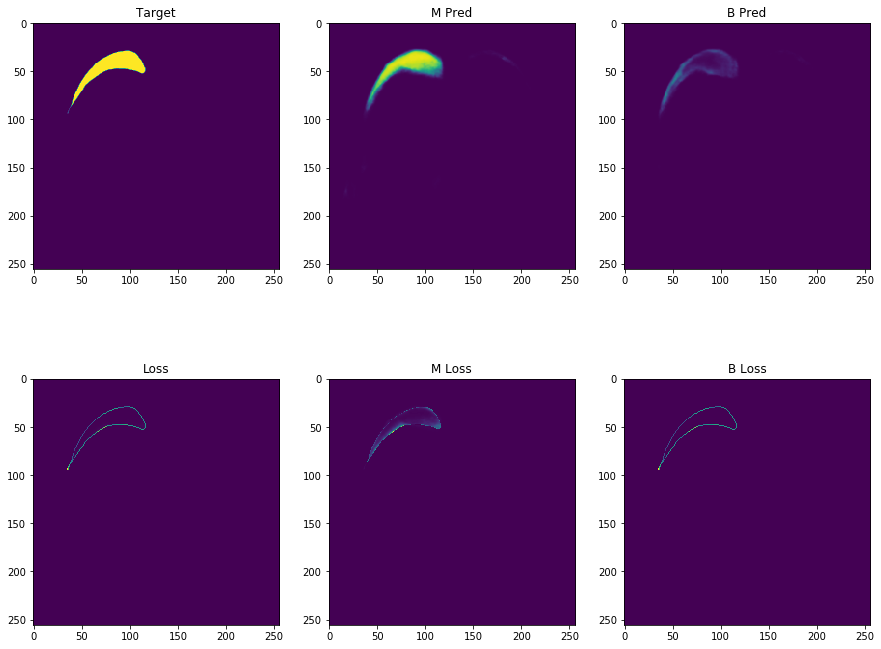

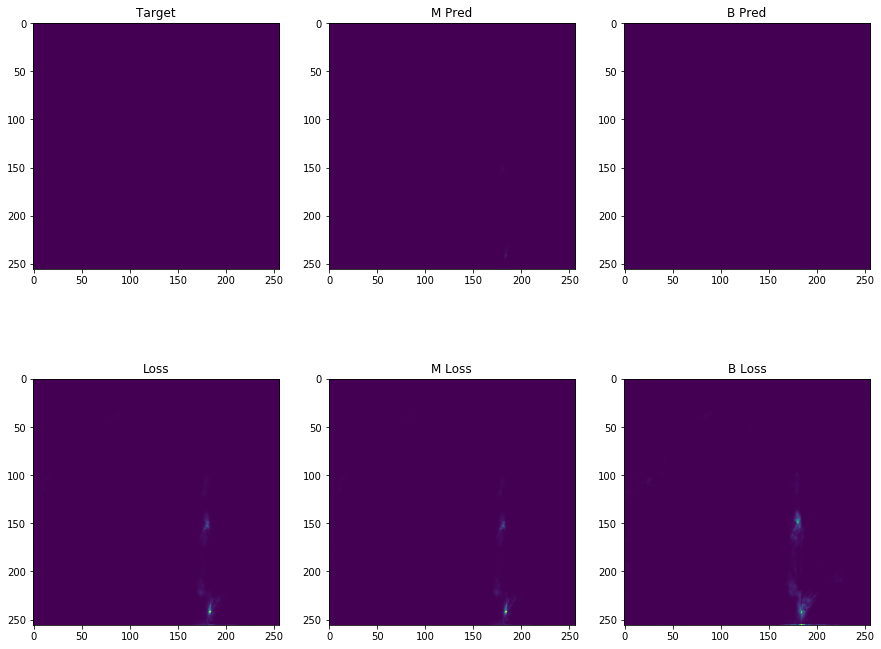

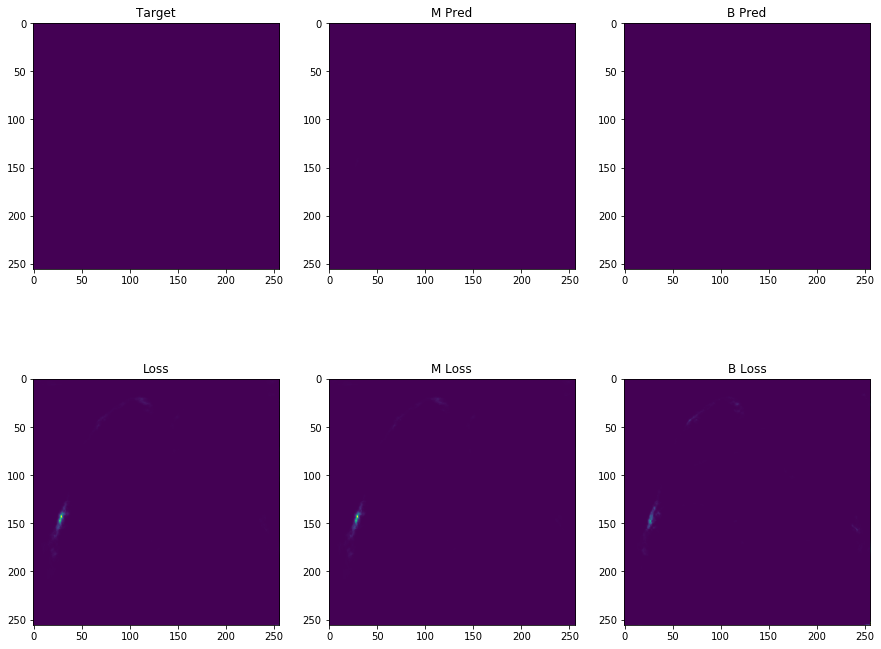

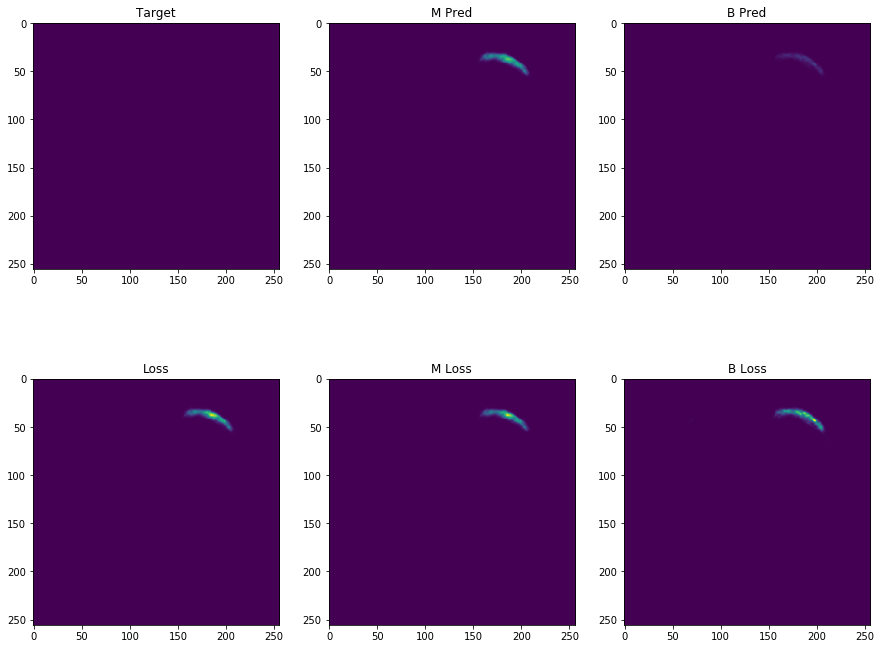

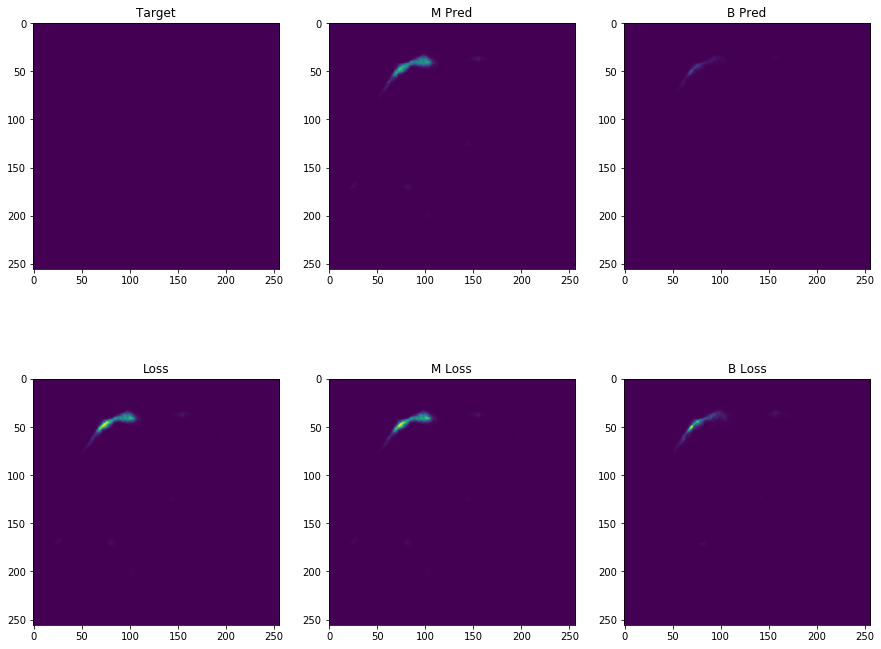

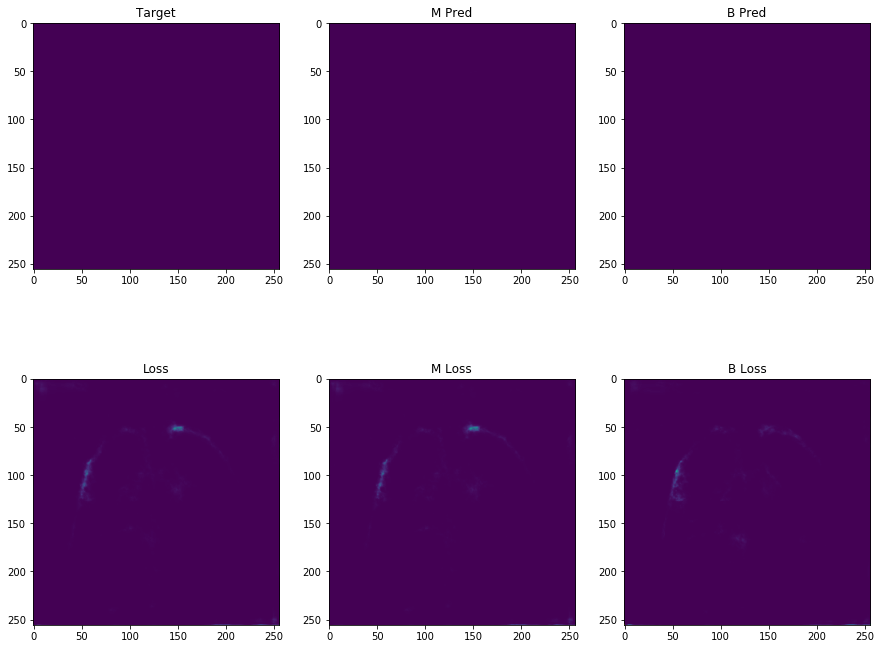

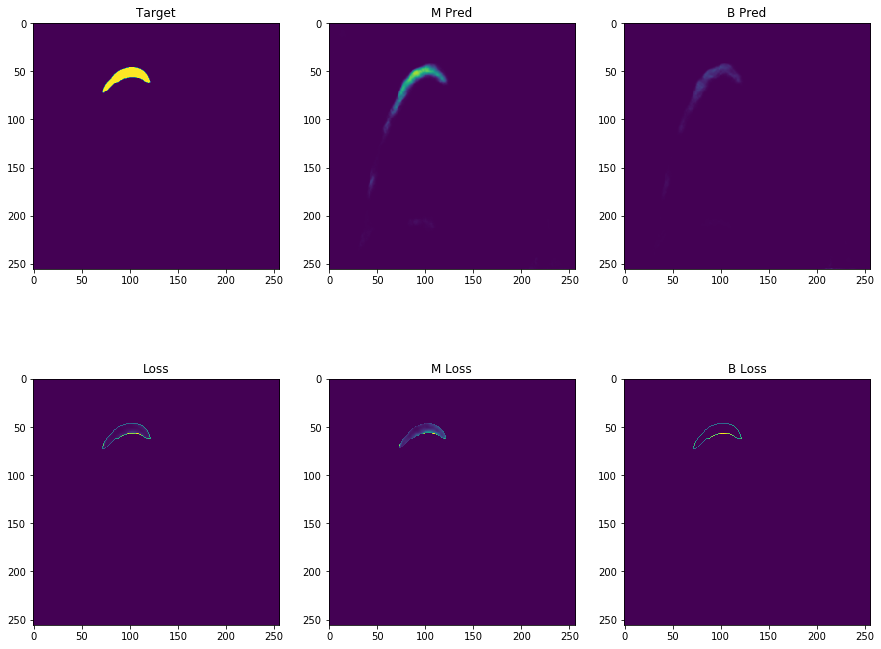

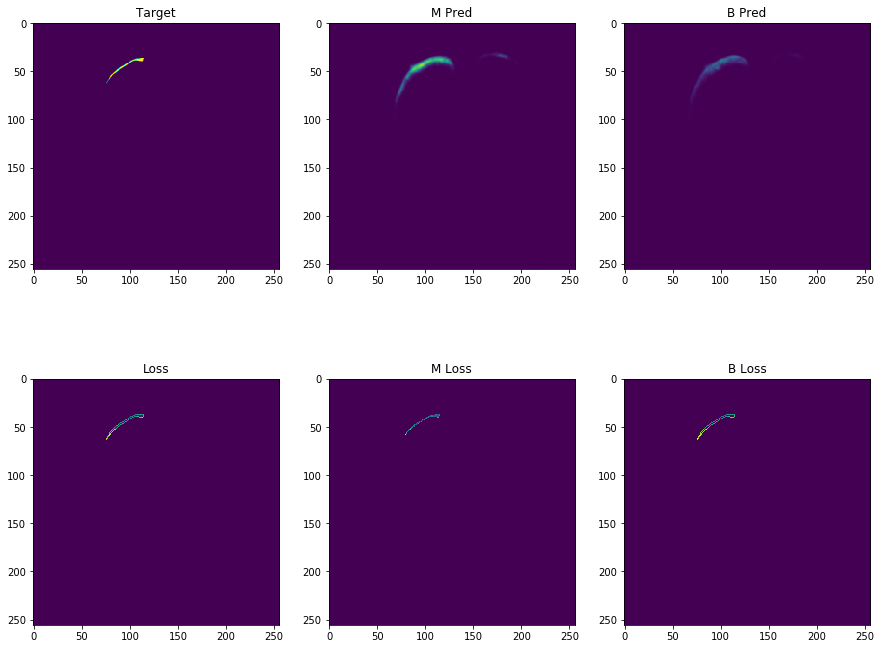

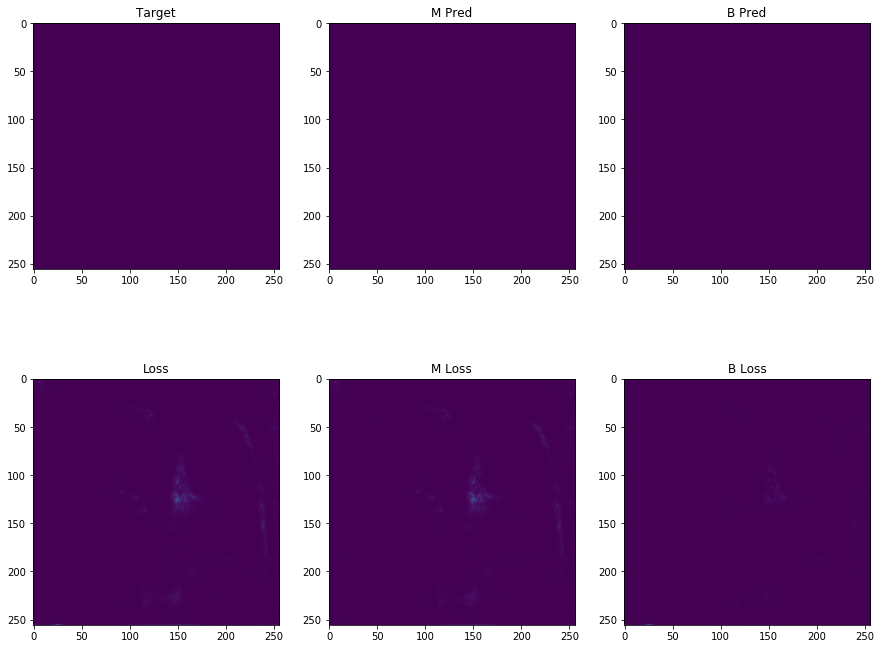

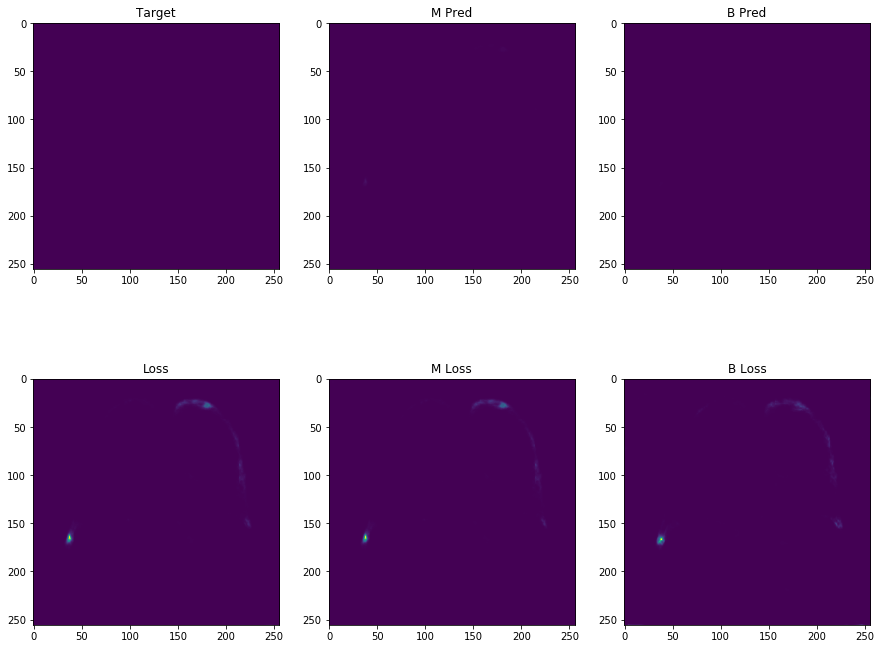

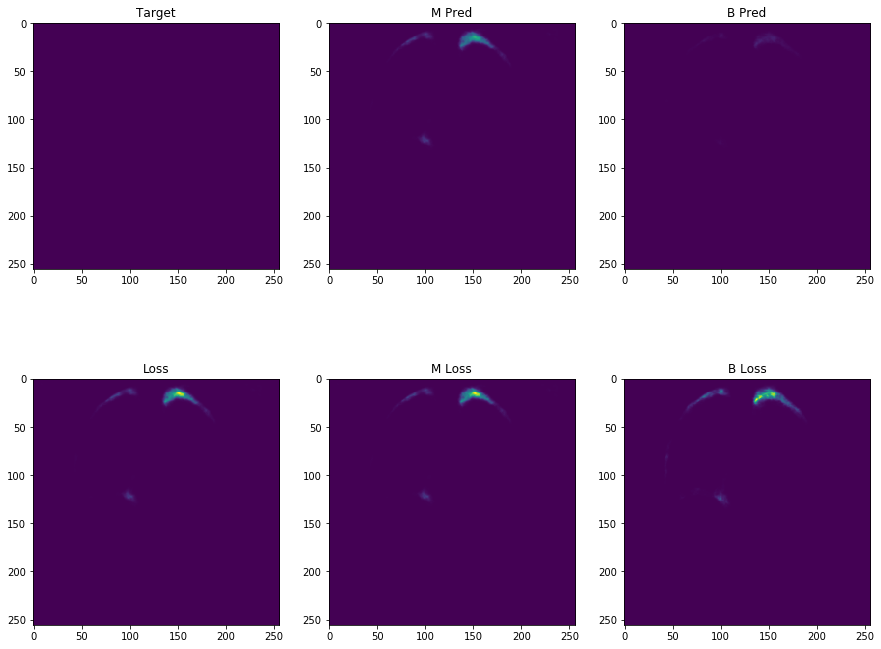

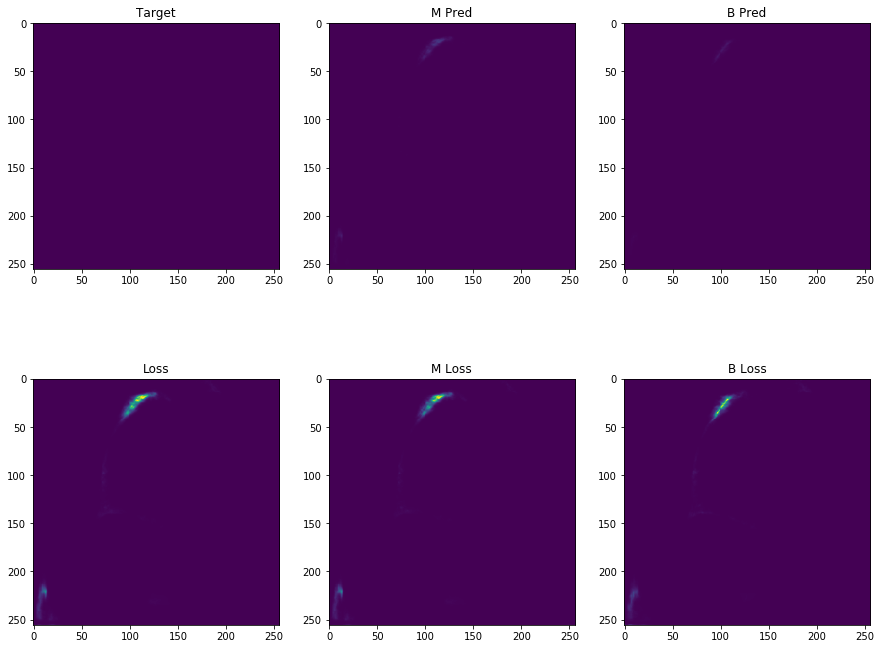

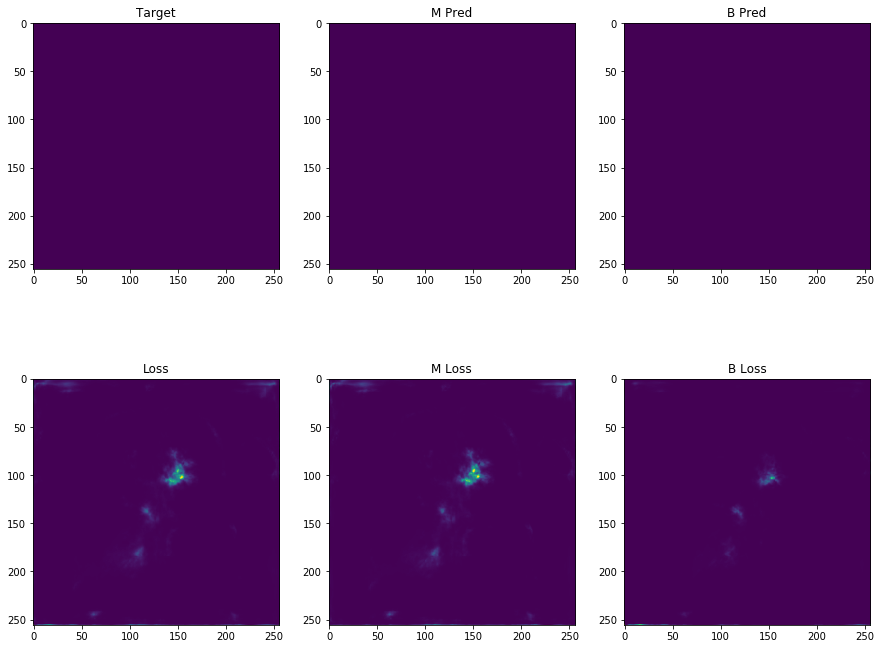

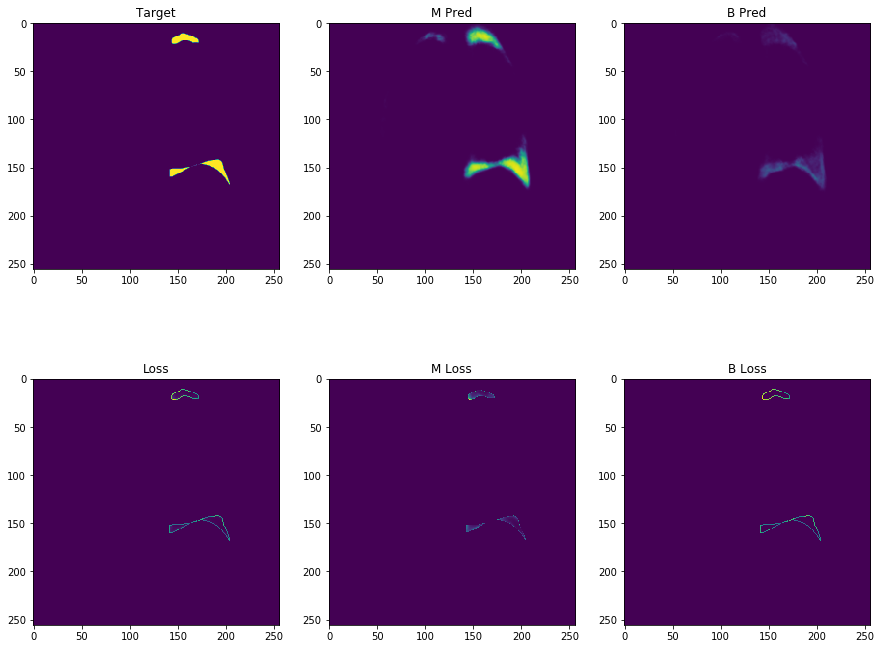

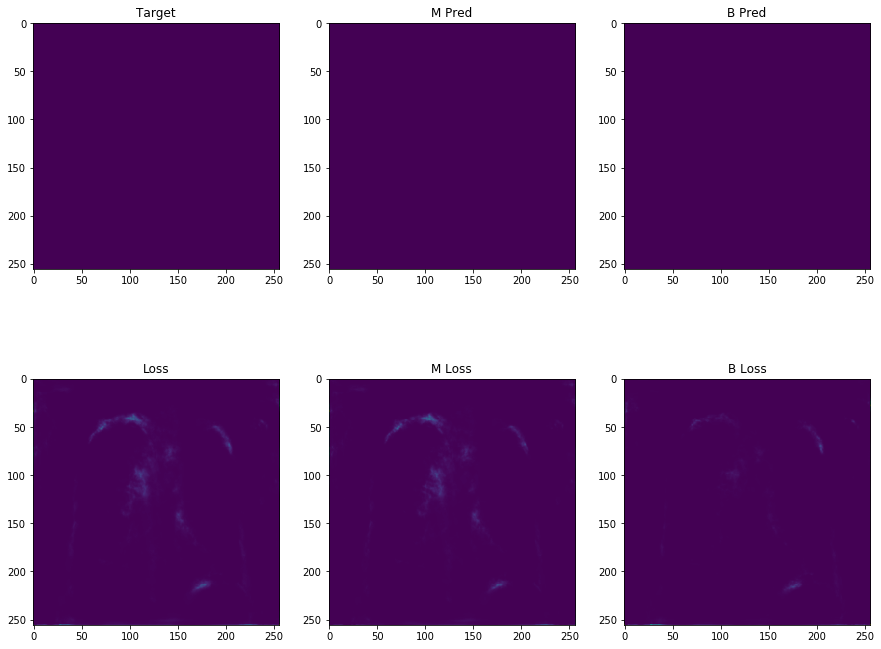

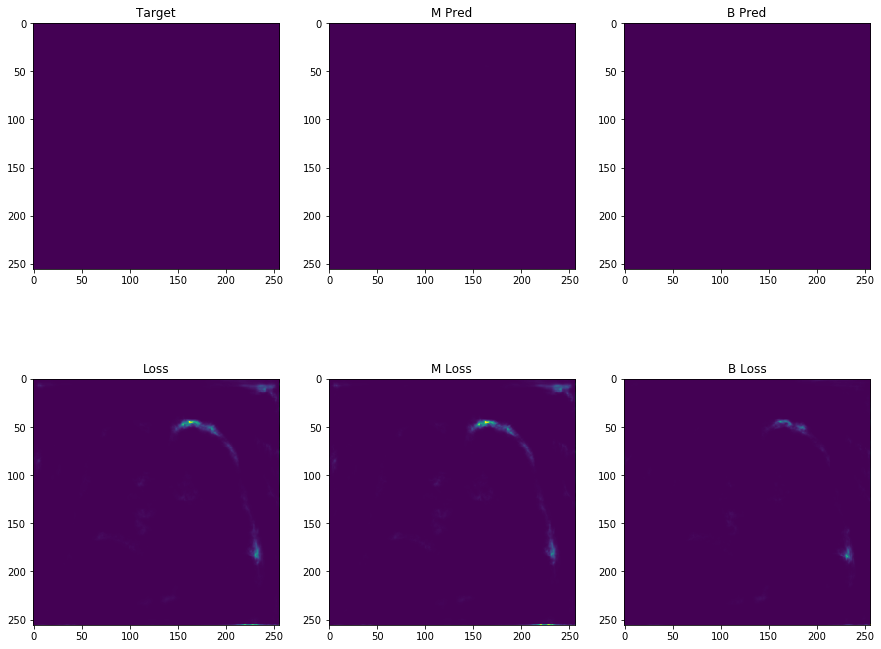

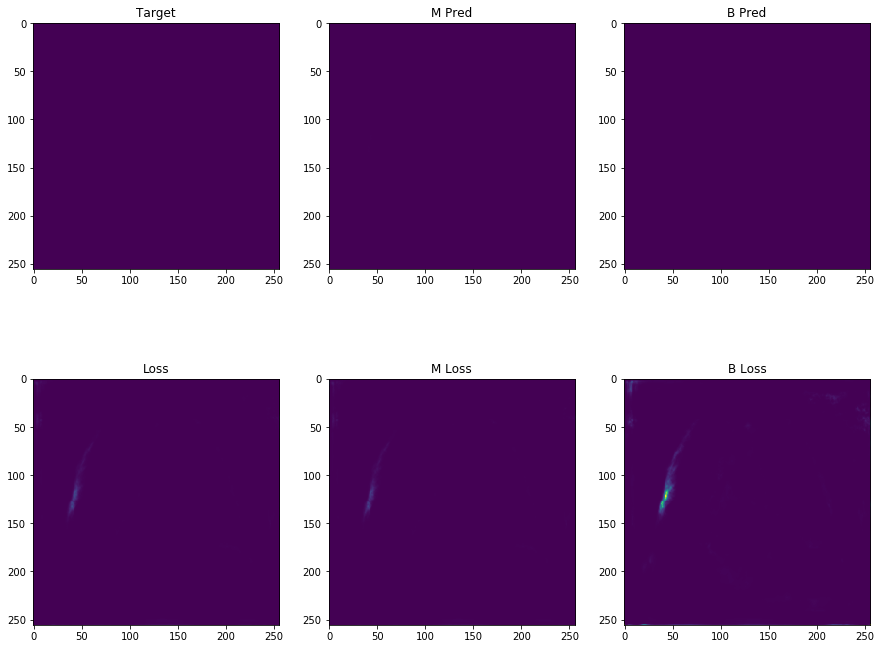

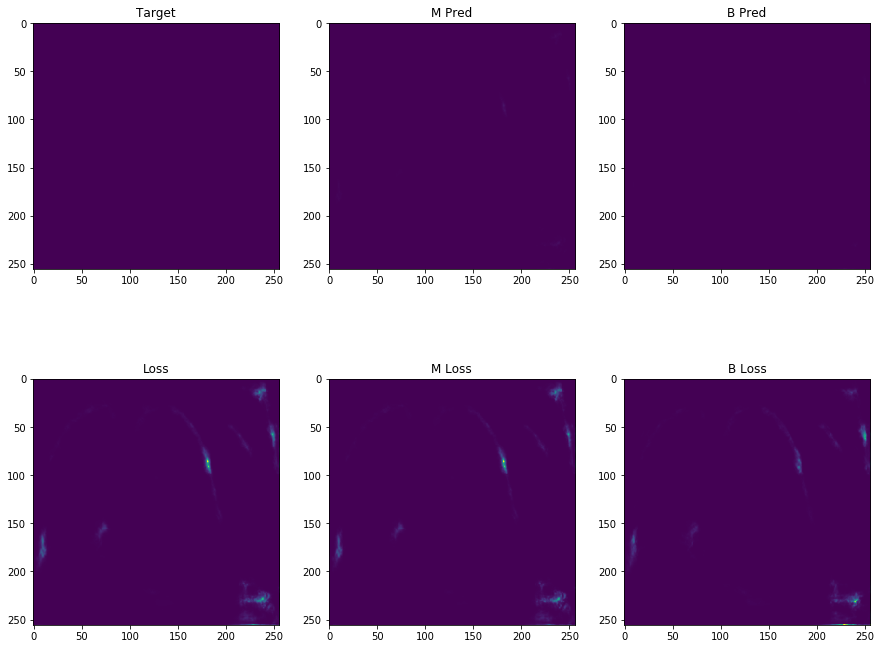

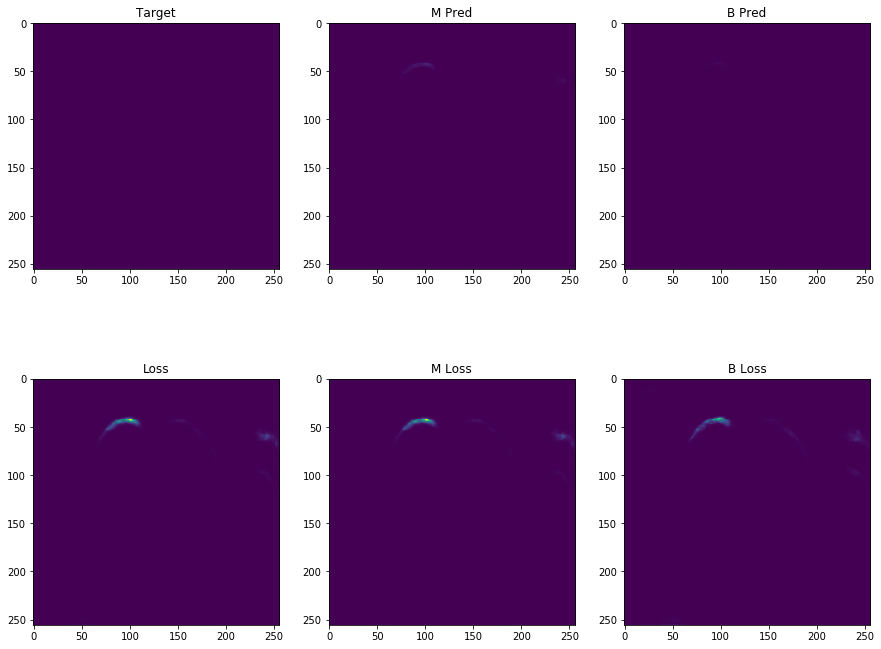

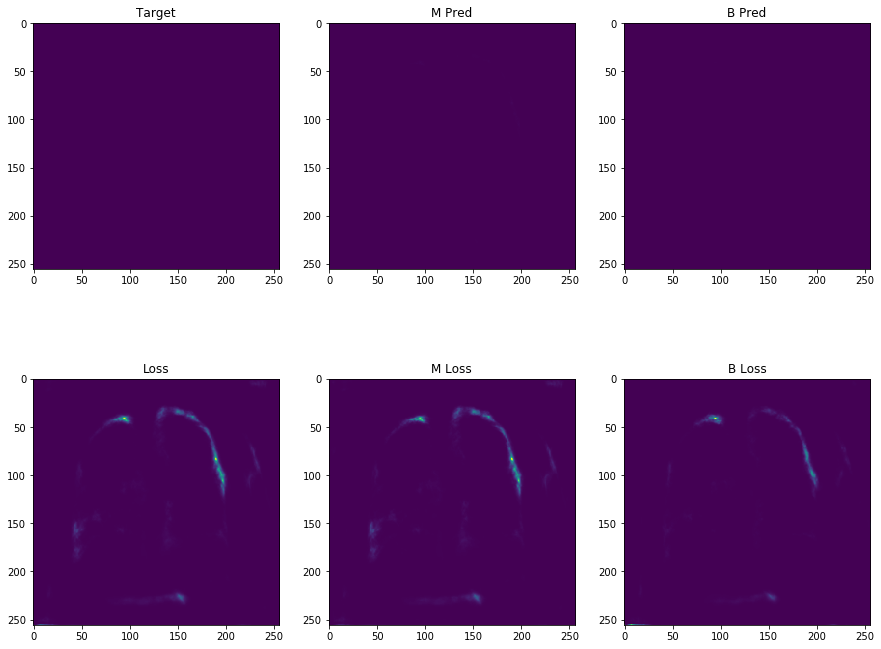

In [8]:
plot_num = 0
plot_count = 10

weights = [0.25, 0.75]

net = Net().cuda()
net.load_state_dict(torch.load('bes-cp-5.pth'))

net.set_mode('train')

for input, truth, index, cache in val_loader:
    input = input.cuda().float()
    truth = truth.cuda().float()
    
    with torch.no_grad():
        b_masks = (get_boundary(truth).float().cuda() / 255.).float()

    m_logit, b_logit = net(input)
    
    m_prob = torch.sigmoid(m_logit)
    b_prob = torch.sigmoid(b_logit)

    b_loss = net.boundary_criterion(b_logit, b_masks, weights=weights, reduction=False)
    m_loss = net.mask_criterion(m_logit, b_logit, truth, b_masks, alpha=5., beta=0.2, weights=weights, reduction=False)

    loss = b_loss + m_loss
    
    if plot_num < plot_count:
        plot_bes_loss(input, truth, m_prob, b_prob, loss, m_loss, b_loss)

    plot_num += 1
